<a href="https://colab.research.google.com/github/giveyourselfaTRY/M2A-RLD-TP-PROJET/blob/main/TANG%2BRuyi_CHEN%2BGuanyu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, you will code a naive actor-critic algorithm in the tabular case. Then you will tune it using grid search and Bayesian optimization, potentially using the [optuna](https://optuna.readthedocs.io/en/stable/) library.
Finally, you will get the best hyper-parameters obtained with both methods and perform a statistical test to see if there is a statistically significant difference between these methods and with respect to naive hyper-parameter values.



This jupyter notebook is written by Ruyi TANG and Guanyu CHEN.

## Install libraries

In [1]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install 'easypip>=1.2.0'")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("swig")
easyinstall("bbrl>=0.2.2")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")
easyinstall("optuna")
easyinstall("gymnasium")
easyinstall("mazemdp")

import numpy as np
import os
from typing import List

import hydra
import optuna
import yaml
from omegaconf import OmegaConf, DictConfig

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

In [2]:
import torch
import torch.nn as nn

In [3]:
import gymnasium as gym

from bbrl.utils.chrono import Chrono

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

from mazemdp.toolbox import sample_categorical
from mazemdp.mdp import Mdp
from bbrl_gymnasium.envs.maze_mdp import MazeMDPEnv
from gymnasium.wrappers.monitoring.video_recorder import VideoRecorder
from functools import partial

# matplotlib.use("TkAgg")

Matplotlib backend: module://matplotlib_inline.backend_inline


# Step 1: Coding the naive Actor-critic algorithm

We consider the naive actor-critic algorithm with a categorical policy.
The algorithm learns a critic with the standard temporal difference mechanism
using a learning rate $\alpha_{critic}$.

We consider a value-based critic $V(s)$. The extension to an action value function $Q(s,a)$ is straightforward.

To update the critic, the algorithm computes the temporal difference error:

$$\delta_t = r(s_t, a_t) + \gamma V^{(n)}(s_{t+1})-V^{(n)}(s_t).$$

Then it applies it to the critic:

$$V^{(n+1)}(s_t) = V^{(n)}(s_t) + \alpha_{critic} \delta_t.$$

To update the actor, the general idea is the same, using the temporal difference error with another learning rate $\alpha_{actor}$.

However, naively applying the same learning rule would not ensure that the probabilities of all actions in a state sum to 1.
Besides, when the temporal difference error $\delta_t$ is negative, it may happen that the probability of an action gets negative or null, which raises an issue when applying renormalization.

So, instead of applying the naive rule, we apply the following one:
$$
\pi_{temp}(a_t|s_t) =  \begin{cases}
\pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t & \mathrm{if } \pi^{(i)}(a_t|s_t) + \alpha_{actor} \delta_t > 10^{-8}\\
10^{-8} & \mathrm{otherwise.} \\
\end{cases}
$$

Then we can apply renormalization so that the probabilities of actions still sum to 1, with
$$
\forall a, \pi^{(i+1)}(a|s_t) = \frac{\pi_{temp}^{(i+1)}(a|s_t)} {\sum_{a'} \pi_{temp}^{(i+1)}(a'|s_t)}
$$ with
$$
\pi_{temp}^{(i+1)}(a|s_t) =  \begin{cases}
\pi_{temp}(a|s_t) & \mathrm{if } a = a_t\\
\pi^{(i)}(a|s_t) & \mathrm{otherwise.} \\
\end{cases}
$$

## Exercise 1

### 1. Code the naive actor-critic algorithm as specified above.

Some hints:

- a good idea to build this code it to take inspiration from the code of Q-learning, to add an actor (a categorical policy), both learning rates,
and to take care about the renormalization function.

- for the next steps of this lab, having a function to repeatedly call your actor-critic algorithm and save the learning trajectories and
norms of the value function is a good idea.

In [4]:
class Critic:
    def __init__(self, nb_states, alpha=0.5, init_v=0.0):
        self.v = np.zeros(nb_states)
        self.v[:] = init_v
        self.alpha = alpha

    def update(self, x, y, r, gamma):
        delta = r + gamma * self.v[y] - self.v[x]
        self.v[x] += self.alpha * delta

    def get_value_function(self):
        return self.v


class Actor:
    def __init__(self, nb_states, action_space_size, alpha=0.5):
        self.policy = np.ones((nb_states, action_space_size)) / action_space_size
        self.alpha = alpha

    def update(self, x, u, delta):
        if self.policy[x, u] + self.alpha * delta > 1e-8:
            self.policy[x, u] += self.alpha * delta
        else:
            self.policy[x, u] = 1e-8

        self.policy[x] /= np.sum(self.policy[x])  # Normalize the policy

    def get_policy(self):
        return self.policy


def Actor_Critic(mdp, nb_episodes=20, timeout=50, alpha_critic=0.5, alpha_actor=0.5, render=True, init_v=0.0, uniform=True):
    # Initialize Critic and Actor
    critic = Critic(mdp.unwrapped.nb_states, alpha=alpha_critic, init_v=init_v)
    actor = Actor(mdp.unwrapped.nb_states, mdp.action_space.n, alpha=alpha_actor)

    v_list = []
    time_list = []

    mdp.timeout = timeout  # episode length

    if render:
        mdp.init_draw("Actor-Critic")

    for _ in range(nb_episodes):
        # Draw the first state of episode i using a uniform distribution over all the states
        x, _ = mdp.reset(uniform=uniform)
        cpt = 0

        terminated = False
        truncated = False
        while not (terminated or truncated):
            # Show the agent in the maze
            if render:
                mdp.draw_v_pi(critic.get_value_function(), actor.get_policy().argmax(axis=1))

            # Draw an action
            u = np.random.choice(mdp.action_space.n, p=actor.get_policy()[x])

            # Perform a step of the MDP
            y, r, terminated, truncated, _ = mdp.step(u)

            # Update the Critic
            critic.update(x, y, r, mdp.unwrapped.gamma)

            # Update the Actor policy
            actor.update(x, u, r + mdp.unwrapped.gamma * critic.get_value_function()[y] - critic.get_value_function()[x])

            # Update the agent position
            x = y
            cpt += 1

        v_list.append(np.linalg.norm(np.maximum(critic.get_value_function(), 0)))
        time_list.append(cpt)

    if render:
        mdp.current_state = 0
        mdp.draw_v_pi(critic.get_value_function(), actor.get_policy())

    return critic.get_value_function(), v_list, time_list


### 2. Provide a plot function

Your plot function should show the evolution through time of number of steps the agent takes to find the reward in the maze.
If your algorithm works, this number of steps should decrease through time.

Your plot function should also show a mean and a standard deviation (or some more advanced statistics) over a collection of learning runs.

In [5]:
# To be completed...
def plot_learning_curve(time_list, nb_episodes):
    """
    Plot the learning curve showing the evolution of the number of steps over episodes.

    Parameters:
        time_list (list of lists): A list containing lists of steps for each episode from multiple runs.
        nb_episodes (int): Number of episodes.
    """
    # Convert time_list into a numpy array for easier manipulation
    time_array = np.array(time_list)

    # Calculate the mean and standard deviation
    mean_steps = time_array.mean(axis=0)
    std_steps = time_array.std(axis=0)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_steps, label='Mean Steps', color='b')
    plt.fill_between(range(nb_episodes), mean_steps - std_steps, mean_steps + std_steps,
                     color='b', alpha=0.2, label='±1 Std Dev')

    plt.title('Learning Curve: Steps to Reach Reward Over Episodes')
    plt.xlabel('Episodes')
    plt.ylabel('Number of Steps')
    plt.legend()
    plt.grid()
    plt.savefig(
        f"./Learning Curve.png", bbox_inches="tight", dpi=100)
    plt.show()




In [6]:
import matplotlib.animation as animation


# Create directory for saving videos
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

def plot_dynamic_learning_curve(time_list, nb_episodes, video_filename="learning_curve_animation.mp4"):
    """
    Plot the dynamic learning curve showing the evolution of the number of steps over episodes as an animation.

    Parameters:
        time_list (list of lists): A list containing lists of steps for each episode from multiple runs.
        nb_episodes (int): Number of episodes.
        video_filename (str): Filename for the output video.
    """
    # Convert time_list into a numpy array for easier manipulation
    time_array = np.array(time_list)

    # Calculate the mean and standard deviation
    mean_steps = time_array.mean(axis=0)
    std_steps = time_array.std(axis=0)

    # Create figure and axis for learning curve
    fig, ax = plt.subplots(figsize=(10, 6))

    # Function to update the plot for each frame (episode)
    def update_curve(episode):
        ax.clear()  # Clear the axis
        ax.plot(range(episode), mean_steps[:episode], label='Mean Steps', color='b')
        ax.fill_between(range(episode), mean_steps[:episode] - std_steps[:episode], mean_steps[:episode] + std_steps[:episode],
                        color='b', alpha=0.2, label='±1 Std Dev')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('Number of Steps')
        ax.set_title(f'Learning Curve: Steps Over Episodes (Up to Episode {episode})')
        ax.legend()
        ax.grid(True)

    # Animate the learning curve over all episodes
    anim = animation.FuncAnimation(fig, update_curve, frames=nb_episodes, interval=200)

    # Save the animation as an mp4 video
    anim.save(f'./videos/{video_filename}', writer='ffmpeg', fps=5)

    # Display the generated video
    return Video(f'./videos/{video_filename}')




## Actor-critic hyper-parameters

To represent the hyper-parameters of the experiments performed in this notebook, we suggest using the dictionary below.
This dictionary can be read using omegaconf.
Using it is not mandatory.
You can also change the value of hyper-parameters or environment parameters at will.

In [7]:
ac_params = {
    "save_curves": False,
    "save_heatmap": True,
    "mdp": {
        "name": "MazeMDP-v0",
        "width": 5,
        "height": 5,
        "ratio": 0.2,
        "render_mode": "rgb_array",
        },

    "log_dir": "./tmp",
    "video_dir": "./tmp/videos",

    "nb_episodes": 150,
    "timeout": 200,
    "render": False, # True, #
    "nb_repeats": 5,

    "alpha_critic": 0.5,
    "alpha_actor": 0.5,
    }

### 3. Test your code

Once everything looks OK, save the obtained plot for your lab report

In [8]:
# To be completed...

env = gym.make(
    id="MazeMDP-v0",
    kwargs={"width": 5, "height": 5, "ratio": 0.2},
    render_mode="rgb_array",
)

env.reset()
# env.unwrapped.init_draw("The maze")

(18, {})

In [9]:
def run_multiple_episodes(mdp, nb_runs, nb_episodes, timeout, alpha_critic, alpha_actor, render):
    all_time_lists = []
    for run in range(nb_runs):
        _, time_list, _ = Actor_Critic(mdp, nb_episodes, timeout, alpha_critic, alpha_actor, render)
        all_time_lists.append(time_list)
    return all_time_lists

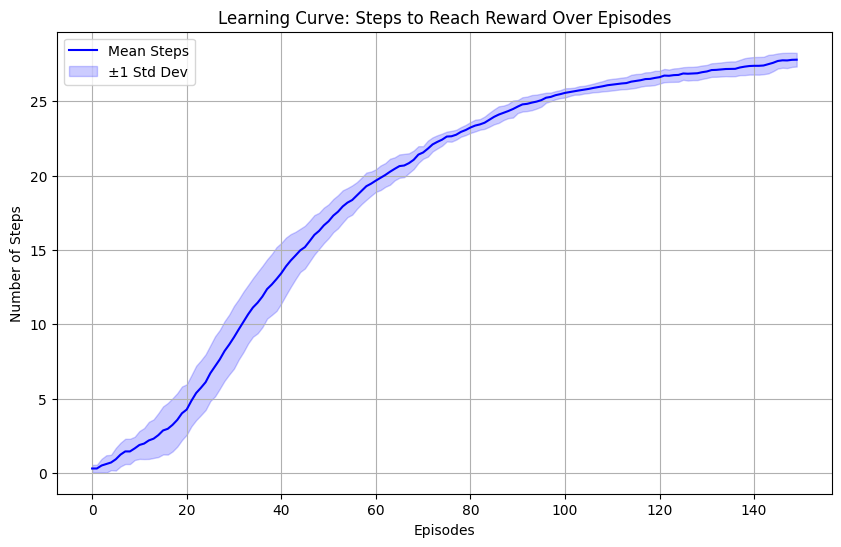

In [10]:
all_time_lists = run_multiple_episodes(
        mdp = env,
        nb_runs=ac_params['nb_repeats'],
        nb_episodes=ac_params['nb_episodes'],
        timeout=ac_params['timeout'],
        alpha_critic=ac_params['alpha_critic'],
        alpha_actor=ac_params['alpha_actor'],
        render=ac_params['render']
    )

plot_learning_curve(all_time_lists, ac_params['nb_episodes'])


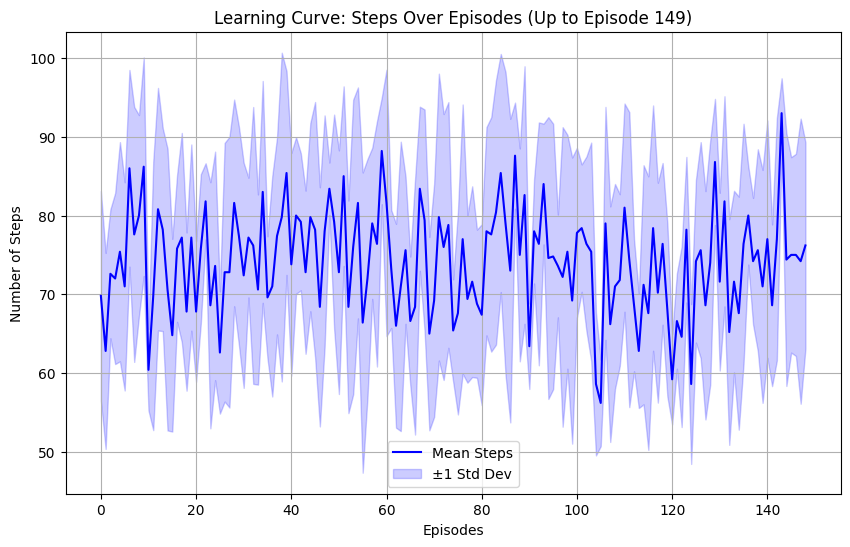

In [11]:
time_list = [np.random.randint(50, 100, ac_params["nb_episodes"]) for _ in range(ac_params["nb_repeats"])]
nb_episodes = ac_params["nb_episodes"]

# Call function to plot dynamic learning curve
video = plot_dynamic_learning_curve(time_list, nb_episodes)


# Display the learning curve video if save_curves is enabled
if ac_params["save_curves"]:
    video.display()

# Step 2: Tuning hyper-parameters

In this part, you have to optimize two hyper-parameters of the actor-critic algorithm, namely the actor and critic learning rates.
You have to do so using a simple grid search method and some Bayesian optimization method.
For the latter, we suggest using the default sampler from [optuna](https://optuna.readthedocs.io/en/stable/).
Follow the above link to understand how optuna works.
Note that it also supports grid search and many other hyper-parameters tuning algorithms.

You should make sure that the hyper-parameters tuning algorithms that you compare benefit from the same training budget
We suggest 400 training runs overall for each method,
which means 20 values each for the actor and the critic learning rates in the case of grid search.

## Exercise 2

### 1. Perform hyper-parameters tuning with two algorithms as suggested above.

### 2. Provide a "heatmap" of the norm of the value function given the hyper-parameters, after training for each pair of hyper-parameters.

### 3. Collect the value of the best hyper-parameters found with each algorithm. You will need them for Step 3.

### 4. Include in your report the heatmaps and the best hyper-parameters found for each method.

In [12]:
# Hyperparameters for grid search
num_points = 20 # Number of points in the grid for each learning rate
learning_rate_range = np.linspace(0.01, 1.0, num_points)  # Learning rates range for both actor and critic
best_actor_lr = None
best_critic_lr = None
best_value_norm = -np.inf

def grid_search(mdp,num_runs,nb_episodes, timeout, alpha_critic, alpha_actor, render):
  global best_actor_lr,best_critic_lr,best_value_norm

  value_norms = np.zeros((num_points, num_points))

  for i, alpha_actor in enumerate(learning_rate_range):
    for j, alpha_critic in enumerate(learning_rate_range):
      # print(f"Testing Actor LR: {alpha_actor:.2f}, Critic LR: {alpha_critic:.2f}")
      all_time_lists = []

      for run in range(num_runs):
        v, v_list, _ = Actor_Critic(mdp, nb_episodes, timeout, alpha_critic, alpha_actor, render)

        # Store the final norm of the value function
        final_value_norm = np.linalg.norm(v)
        value_norms[i, j] = final_value_norm

        # Update best hyperparameters if needed
        if final_value_norm >= best_value_norm:
          best_value_norm = final_value_norm
          best_actor_lr = alpha_actor
          best_critic_lr = alpha_critic
          # Print the current best value and the corresponding hyperparameters
          print(f"New best value norm: {best_value_norm:.4f} (Actor LR: {best_actor_lr:.2f}, Critic LR: {best_critic_lr:.2f})")

  return value_norms, best_actor_lr, best_critic_lr



In [13]:
# Function to plot heatmap
def plot_heatmap(value_norms, method_name):
    plt.figure(figsize=(10, 8))
    plt.imshow(value_norms, interpolation='nearest')
    plt.colorbar(label='Norm of Value Function')
    plt.xticks(ticks=np.arange(num_points), labels=[f"{lr:.2f}" for lr in learning_rate_range], rotation=45)
    plt.yticks(ticks=np.arange(num_points), labels=[f"{lr:.2f}" for lr in learning_rate_range])
    plt.xlabel('Actor Learning Rate')
    plt.ylabel('Critic Learning Rate')
    plt.title(f"{method_name} Heatmap of Norm of Value Function")
    plt.tight_layout()
    plt.savefig(f"{method_name}_heatmap", bbox_inches="tight", dpi=100)
    plt.show()

New best value norm: 0.4478 (Actor LR: 0.01, Critic LR: 0.01)
New best value norm: 0.5166 (Actor LR: 0.01, Critic LR: 0.01)
New best value norm: 3.0660 (Actor LR: 0.01, Critic LR: 0.06)
New best value norm: 3.3637 (Actor LR: 0.01, Critic LR: 0.06)
New best value norm: 8.9507 (Actor LR: 0.01, Critic LR: 0.11)
New best value norm: 9.7089 (Actor LR: 0.01, Critic LR: 0.17)
New best value norm: 12.0244 (Actor LR: 0.01, Critic LR: 0.22)
New best value norm: 12.4883 (Actor LR: 0.01, Critic LR: 0.22)
New best value norm: 13.8605 (Actor LR: 0.01, Critic LR: 0.22)
New best value norm: 14.0060 (Actor LR: 0.01, Critic LR: 0.27)
New best value norm: 15.2919 (Actor LR: 0.01, Critic LR: 0.32)
New best value norm: 16.4658 (Actor LR: 0.01, Critic LR: 0.32)
New best value norm: 17.6490 (Actor LR: 0.01, Critic LR: 0.37)
New best value norm: 17.8451 (Actor LR: 0.01, Critic LR: 0.48)
New best value norm: 18.2786 (Actor LR: 0.01, Critic LR: 0.58)
New best value norm: 19.4482 (Actor LR: 0.01, Critic LR: 0.64

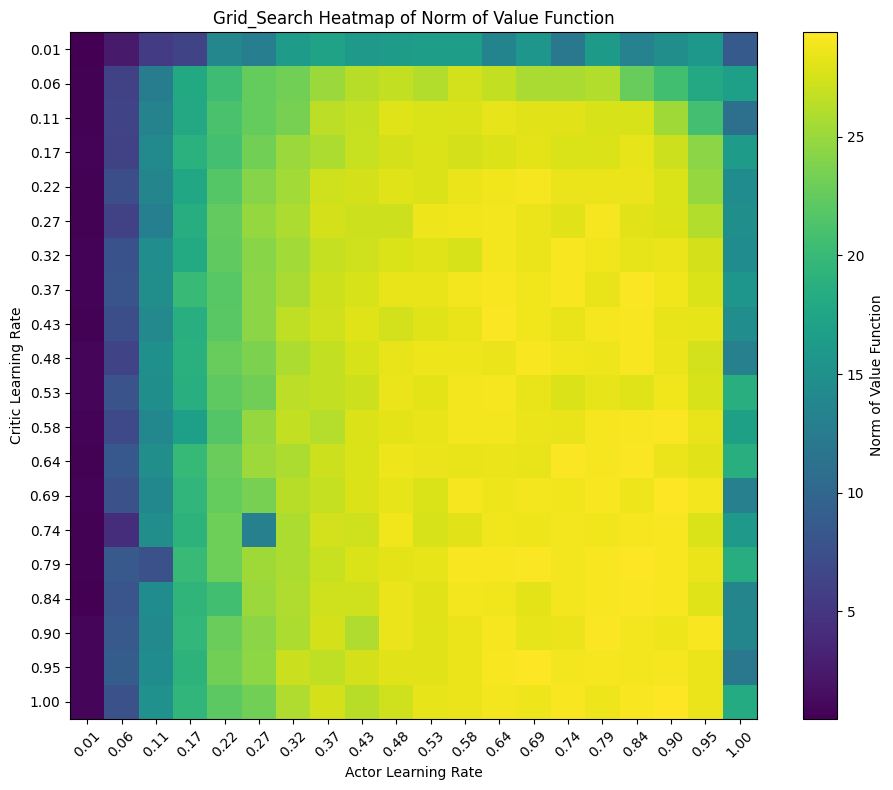

In [14]:
# Main function to execute grid search and save heatmap

# Run grid search
value_norms, best_actor_lr, best_critic_lr = grid_search(
    mdp=env,
    num_runs=ac_params['nb_repeats'],
    nb_episodes=ac_params['nb_episodes'],
    timeout=ac_params['timeout'],
    alpha_critic=ac_params['alpha_critic'],
    alpha_actor=ac_params['alpha_actor'],
    render=ac_params['render']
)

print("Best Actor Learning Rate:", best_actor_lr)
print("Best Critic Learning Rate:", best_critic_lr)
print("Best Norm of Value Function:", best_value_norm)

plot_heatmap(value_norms, 'Grid_Search')

In [15]:
# Hyperparameters for random search

# Number of training runs
total_training_runs = 400
num_random_samples = total_training_runs

# Learning rate range for random search
learning_rate_range = (0.01, 1.0)

# Function to randomly sample learning rates
def sample_learning_rate():
    return np.random.uniform(learning_rate_range[0], learning_rate_range[1])


results_random=[]
# Random search for hyper-parameter tuning
def random_search(mdp, num_runs, nb_episodes, timeout, render):
    best_actor_lr = None
    best_critic_lr = None
    best_value_norm = -np.inf
    sampled_actor_critic_pairs = []
    value_norms = []

    for run in range(num_random_samples):
        alpha_actor = sample_learning_rate()
        alpha_critic = sample_learning_rate()

        # Store the pair of learning rates
        sampled_actor_critic_pairs.append((alpha_actor, alpha_critic))

        # Store the final value norms over multiple repeats
        all_value_norms = []

        for repeat in range(num_runs):
            v, v_list, _ = Actor_Critic(mdp, nb_episodes, timeout, alpha_critic, alpha_actor, render)
            final_value_norm = np.linalg.norm(v)
            all_value_norms.append(final_value_norm)

        avg_value_norm = np.mean(all_value_norms)
        value_norms.append(avg_value_norm)

        # Update best hyperparameters if needed
        if avg_value_norm > best_value_norm:
            best_value_norm = avg_value_norm
            best_actor_lr = alpha_actor
            best_critic_lr = alpha_critic


            results_random.append((alpha_actor, alpha_critic, avg_value_norm))

            print(f"New best value norm: {best_value_norm:.4f} (Actor LR: {best_actor_lr:.2f}, Critic LR: {best_critic_lr:.2f})")

    return sampled_actor_critic_pairs, value_norms, best_actor_lr, best_critic_lr

# Function to create a heatmap
def plot_random_search_scatter(sampled_pairs, value_norms):
    # Convert learning rates and value norms to 2D arrays for heatmap plotting
    actor_lrs = [pair[0] for pair in sampled_pairs]
    critic_lrs = [pair[1] for pair in sampled_pairs]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(actor_lrs, critic_lrs, c=value_norms, cmap='viridis', s=100, edgecolor='k')
    plt.colorbar(scatter, label='Norm of Value Function')
    plt.xlabel('Actor Learning Rate')
    plt.ylabel('Critic Learning Rate')
    plt.title('Random Search - Heatmap of Norm of Value Function')
    plt.tight_layout()
    plt.savefig(f"Random_Search_heatmap", bbox_inches="tight", dpi=100)
    plt.show()

New best value norm: 25.4155 (Actor LR: 0.27, Critic LR: 0.31)
New best value norm: 28.0291 (Actor LR: 0.27, Critic LR: 0.85)
New best value norm: 28.8349 (Actor LR: 0.57, Critic LR: 0.85)
New best value norm: 28.8817 (Actor LR: 0.83, Critic LR: 0.65)
New best value norm: 29.0455 (Actor LR: 0.87, Critic LR: 0.74)
New best value norm: 29.0879 (Actor LR: 0.66, Critic LR: 0.81)
New best value norm: 29.2394 (Actor LR: 0.88, Critic LR: 0.83)
Best Actor Learning Rate (Random Search): 0.8780981019455959
Best Critic Learning Rate (Random Search): 0.8291984118282346


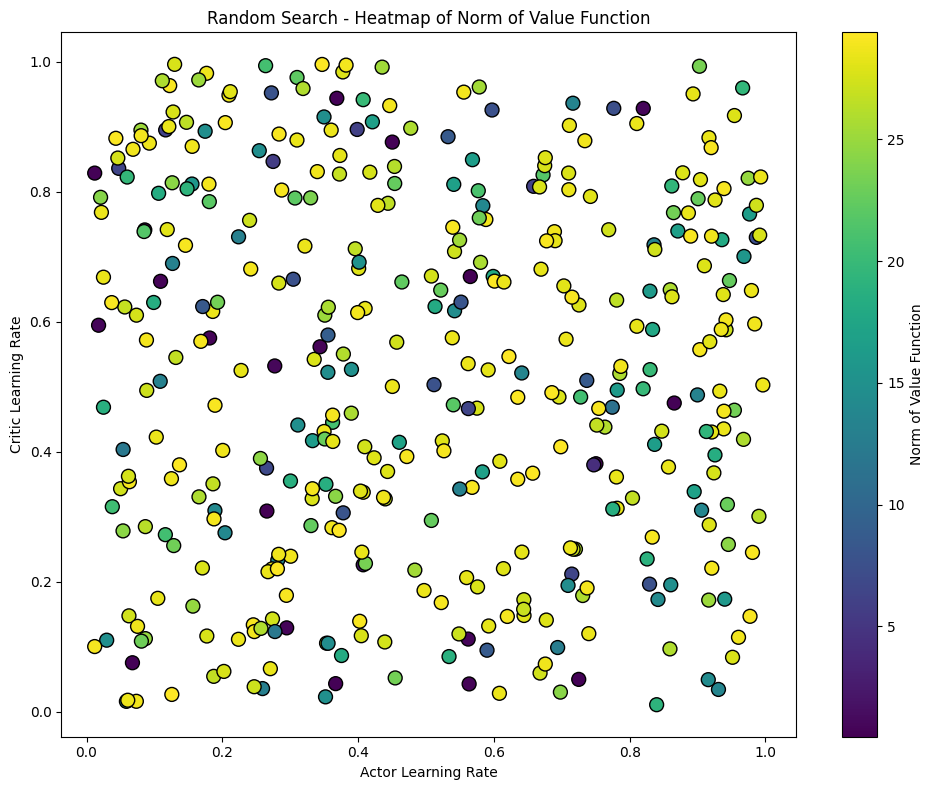

In [16]:
sampled_pairs, rs_value_norms, best_actor_lr_random, best_critic_lr_random = random_search(
        mdp = env,
        num_runs=ac_params['nb_repeats'],
        nb_episodes=ac_params['nb_episodes'],
        timeout=ac_params['timeout'],
        render=ac_params['render']
    )

print("Best Actor Learning Rate (Random Search):", best_actor_lr_random)
print("Best Critic Learning Rate (Random Search):", best_critic_lr_random)

plot_random_search_scatter(sampled_pairs, value_norms)

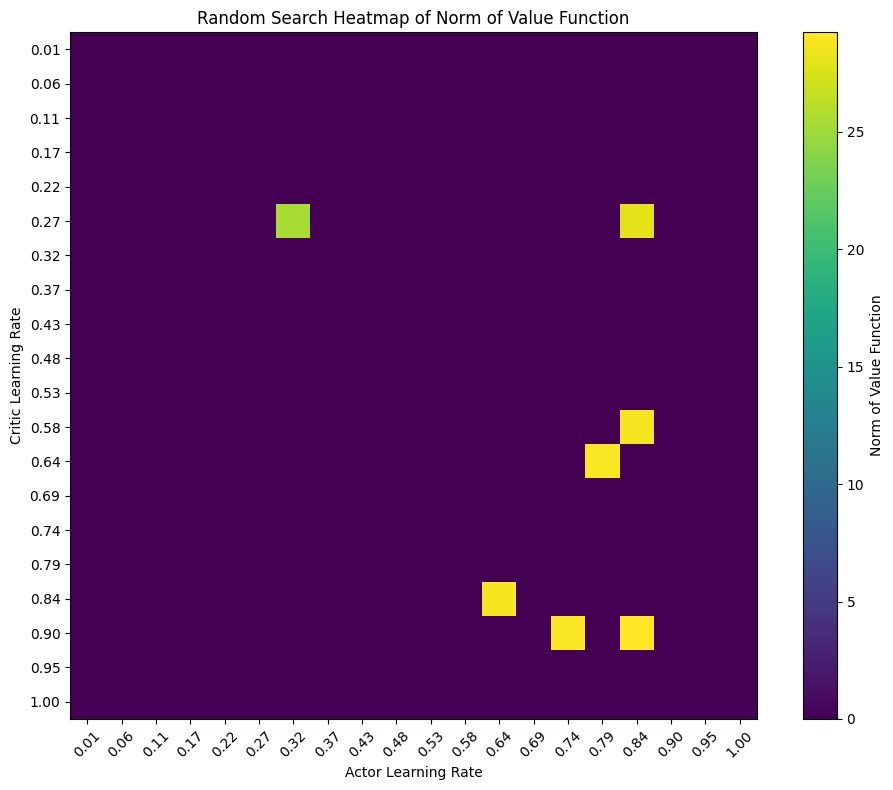

In [17]:
# Define the grid for learning rates
num_points = 20  # Number of points for the grid
learning_rate_range = np.linspace(0.01, 1.0, num_points)



# Initialize the value function norm matrix
Random_value_norms = np.zeros((20, 20))

# Iterate through the results and map alpha_actor and alpha_critic to the grid
for alpha_actor, alpha_critic, norm_v in results_random:
    # Find the closest indices of alpha_actor and alpha_critic in the grid
    actor_idx = np.argmin(np.abs(learning_rate_range - alpha_actor))
    critic_idx = np.argmin(np.abs(learning_rate_range - alpha_critic))

    # Store the norm value in the matrix
    Random_value_norms[actor_idx, critic_idx] = norm_v

plot_heatmap(Random_value_norms, "Random Search")


In [18]:
# Hyperparameters for Bayesian optimization method (optuna)

import optuna

# Initialize a list to store alpha_actor, alpha_critic, and the norm of the value function
results = []

def objective(trial):
    # Define the search range for alpha_actor and alpha_critic
    alpha_actor = trial.suggest_float("alpha_actor", 0.01, 1.0, log=True)
    alpha_critic = trial.suggest_float("alpha_critic", 0.01, 1.0, log=True)

    # Call the Actor-Critic algorithm, passing in the tuned alpha_actor and alpha_critic
    mdp = env

    v, v_list, time_list = Actor_Critic(
        mdp = env,
        nb_episodes = ac_params["nb_episodes"],
        timeout = ac_params["timeout"],
        alpha_critic = alpha_critic,
        alpha_actor = alpha_actor,
        render = False,
        init_v = 0
    )

    # Calculate the norm
    norm_v = np.linalg.norm(v)

    # Save the alpha_actor, alpha_critic, and the corresponding norm
    results.append((alpha_actor, alpha_critic, norm_v))

    return norm_v

In [19]:
# Create a Study object and specify the optimization direction as maximization
study = optuna.create_study(direction="maximize")

# Run 400 times
study.optimize(objective, n_trials=400)

best_actor_lr_Bayes = study.best_params["alpha_actor"]
best_critic_lr_Bayes = study.best_params["alpha_critic"]

# print the results
print('best alpha_actor: ', best_actor_lr_Bayes)
print('best alpha_critic: ', best_critic_lr_Bayes)
print('best value: ', study.best_value)

[I 2024-10-05 21:36:06,090] A new study created in memory with name: no-name-3627ad17-a2ba-439a-b68f-1cd419b16105


[I 2024-10-05 21:36:06,184] Trial 0 finished with value: 28.63166837858561 and parameters: {'alpha_actor': 0.8312041808932814, 'alpha_critic': 0.9037449460630613}. Best is trial 0 with value: 28.63166837858561.
[I 2024-10-05 21:36:06,420] Trial 1 finished with value: 0.7965390266064759 and parameters: {'alpha_actor': 0.19089660161197175, 'alpha_critic': 0.011965651835258322}. Best is trial 0 with value: 28.63166837858561.
[I 2024-10-05 21:36:06,568] Trial 2 finished with value: 9.62379829653582 and parameters: {'alpha_actor': 0.10126607749228574, 'alpha_critic': 0.08121059582493903}. Best is trial 0 with value: 28.63166837858561.
[I 2024-10-05 21:36:06,715] Trial 3 finished with value: 12.79640067749495 and parameters: {'alpha_actor': 0.08884496141252052, 'alpha_critic': 0.11855070871538002}. Best is trial 0 with value: 28.63166837858561.
[I 2024-10-05 21:36:06,915] Trial 4 finished with value: 11.001792516593179 and parameters: {'alpha_actor': 0.019275188795105137, 'alpha_critic': 0.1

best alpha_actor:  0.8673420813544014
best alpha_critic:  0.8725958260777077
best value:  29.405146924436902


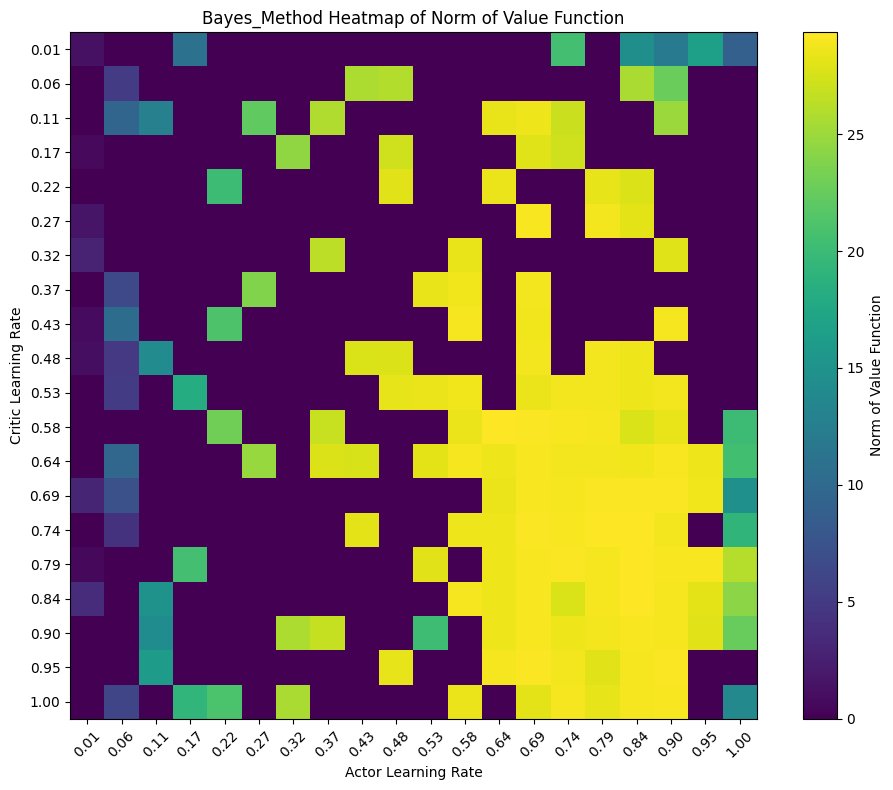

In [20]:
# Define the number of grid points to divide
num_points = 20
learning_rate_range = np.linspace(0.01, 1.0, num_points)

# Initialize the value function norm matrix
Bayes_value_norms = np.zeros((num_points, num_points))

# Iterate through the results and map alpha_actor and alpha_critic to the grid
for alpha_actor, alpha_critic, norm_v in results:
    # Find the closest indices of alpha_actor and alpha_critic in the grid
    actor_idx = np.argmin(np.abs(learning_rate_range - alpha_actor))
    critic_idx = np.argmin(np.abs(learning_rate_range - alpha_critic))

    # Store the norm value in the matrix
    Bayes_value_norms[actor_idx, critic_idx] = norm_v

plot_heatmap(Bayes_value_norms, "Bayes_Method")


# Step 3: Statistical tests

Now you have to compare the performance of the actor-critic algorithm tuned
with all the best hyper-parameters you found before, using statistical tests.

The functions below are provided to run Welch's T-test over learning curves.
They have been adapted from a github repository: https://github.com/flowersteam/rl_stats
You don't need to understand them in detail (though it is always a good idea to try to understand more code).

In [21]:
from scipy.stats import ttest_ind
# import bootstrapped.bootstrap as bs
# import bootstrapped.compare_functions as bs_compare
# import bootstrapped.stats_functions as bs_stats

In [22]:
def compute_central_tendency_and_error(id_central, id_error, sample):

    try:
        id_error = int(id_error)
    except:
        pass

    if id_central == "mean":
        central = np.nanmean(sample, axis=1)
    elif id_central == "median":
        central = np.nanmedian(sample, axis=1)
    else:
        raise NotImplementedError

    if isinstance(id_error, int):
        low = np.nanpercentile(sample, q=int((100 - id_error) / 2), axis=1)
        high = np.nanpercentile(sample, q=int(100 - (100 - id_error) / 2), axis=1)
    elif id_error == "std":
        low = central - np.nanstd(sample, axis=1)
        high = central + np.nanstd(sample, axis=1)
    elif id_error == "sem":
        low = central - np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
        high = central + np.nanstd(sample, axis=1) / np.sqrt(sample.shape[0])
    else:
        raise NotImplementedError

    return central, low, high

In [23]:
def run_test(test_id, data1, data2, alpha=0.05):
    """
    Compute tests comparing data1 and data2 with confidence level alpha
    :param test_id: (str) refers to what test should be used
    :param data1: (np.ndarray) sample 1
    :param data2: (np.ndarray) sample 2
    :param alpha: (float) confidence level of the test
    :return: (bool) if True, the null hypothesis is rejected
    """
    data1 = data1.squeeze()
    data2 = data2.squeeze()
    n1 = data1.size
    n2 = data2.size

    # perform Welch t-test":
    _, p = ttest_ind(data1, data2, equal_var=False)
    return p < alpha

This last function was adapted for the lab.

In [24]:
def perform_test(perf1, perf2, name1, name2, sample_size=20, downsampling_fact=5, confidence_level=0.01):

    perf1 = perf1.transpose()
    perf2 = perf2.transpose()
    nb_datapoints = perf1.shape[1]
    nb_steps = perf1.shape[0]

    legend = [name1, name2]

    # what do you want to plot ?
    id_central = 'mean' # "median"  #
    id_error = 80  # (percentiles), also: 'std', 'sem'

    test_id = "Welch t-test"  # recommended

    sample1 = perf1[:, np.random.randint(0, nb_datapoints, sample_size)]
    sample2 = perf2[:, np.random.randint(0, nb_datapoints, sample_size)]

    steps = np.arange(0, nb_steps, downsampling_fact)
    sample1 = sample1[steps, :]
    sample2 = sample2[steps, :]

    # test
    sign_diff = np.zeros([len(steps)])
    for i in range(len(steps)):
        sign_diff[i] = run_test(
            test_id, sample1[i, :], sample2[i, :], alpha=confidence_level
        )

    central1, low1, high1 = compute_central_tendency_and_error(
        id_central, id_error, sample1
    )
    central2, low2, high2 = compute_central_tendency_and_error(
        id_central, id_error, sample2
    )

    # plot
    _, ax = plt.subplots(1, 1, figsize=(20, 10))
    lab1 = plt.xlabel("training steps")
    lab2 = plt.ylabel("performance")

    plt.plot(steps, central1, linewidth=10)
    plt.plot(steps, central2, linewidth=10)
    plt.fill_between(steps, low1, high1, alpha=0.3)
    plt.fill_between(steps, low2, high2, alpha=0.3)
    leg = ax.legend(legend, frameon=False)

    # plot significative difference as dots
    idx = np.argwhere(sign_diff == 1)
    y = max(np.nanmax(high1), np.nanmax(high2))
    plt.scatter(steps[idx], y * 1.05 * np.ones([idx.size]), s=100, c="k", marker="o")

    # style
    for line in leg.get_lines():
        line.set_linewidth(10.0)
    ax.spines["top"].set_linewidth(5)
    ax.spines["right"].set_linewidth(5)
    ax.spines["bottom"].set_linewidth(5)
    ax.spines["left"].set_linewidth(5)

    plt.savefig(
        f"./{name1}_{name2}.png", bbox_extra_artists=(leg, lab1, lab2), bbox_inches="tight", dpi=100
    )
    # plt.show()

## Exercise 3

As hyper-parameters, you will use:

- naive tuning, that is a pair (0.5, 0.5) for the actor and critic learning rates,
- the best hyper-parameters you found with the different tuning algorithms you used before.

### 1. For each set of hyper-parameters, collect a large dataset of learning curves.

We suggest using 150 training episodes.

### 2. Perform statistical comparisons

- Take two datasets of learning curves obtained with the hyper-parameters sets that you found with different tuning algorithms.
- Use the ``` perform_test(...)``` function to compare each possible pair of sets.

You should obtain an image for each pair you have tried.
In this image, black dots signal the time step where there is a statistically significant difference between two learning curves.

 ### 3. Conclude.

In [57]:
# 1. For each set of hyper-parameters, collect a large dataset of learning curves
def collect_learning_curves(mdp, num_runs, nb_episodes, timeout, alpha_critic, alpha_actor, render):
    learning_curves = []

    for run in range(num_runs):
        v_list = []  # Store value norms or other performance metrics per episode

        # Run Actor-Critic algorithm
        v, v_list, _ = Actor_Critic(
            mdp, nb_episodes,
            timeout,
            alpha_critic,
            alpha_actor,
            render
        )

        # Save learning curve for this run
        learning_curves.append(v_list)

    return np.array(learning_curves)

In [58]:
# naive tuning
naive_alpha_critic = 0.5
naive_alpha_actor = 0.5

naive_curves = collect_learning_curves(
    mdp=env,
    num_runs=ac_params['nb_repeats'],
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=naive_alpha_actor,
    alpha_critic=naive_alpha_critic,
    render=ac_params['render']
)

In [59]:
# Grid Search tuning
grid_search_curves = collect_learning_curves(
    mdp = env,
    num_runs=ac_params['nb_repeats'],
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr,
    alpha_actor=best_actor_lr,
    render=ac_params['render'])

In [60]:
# Random Search tuning
random_search_curves = collect_learning_curves(
    mdp=env,
    num_runs=ac_params['nb_repeats'],
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr_random,
    alpha_actor=best_actor_lr_random,
    render=ac_params['render']
)

In [61]:
# Bayesian optimization method tuning (optuna)
Bayes_alpha_critic = study.best_params["alpha_critic"]
Bayes_alpha_actor = study.best_params["alpha_actor"]

Bayes_curves = collect_learning_curves(
    mdp=env,
    num_runs=ac_params['nb_repeats'],
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=Bayes_alpha_actor,
    alpha_critic=Bayes_alpha_critic,
    render=ac_params['render']
)

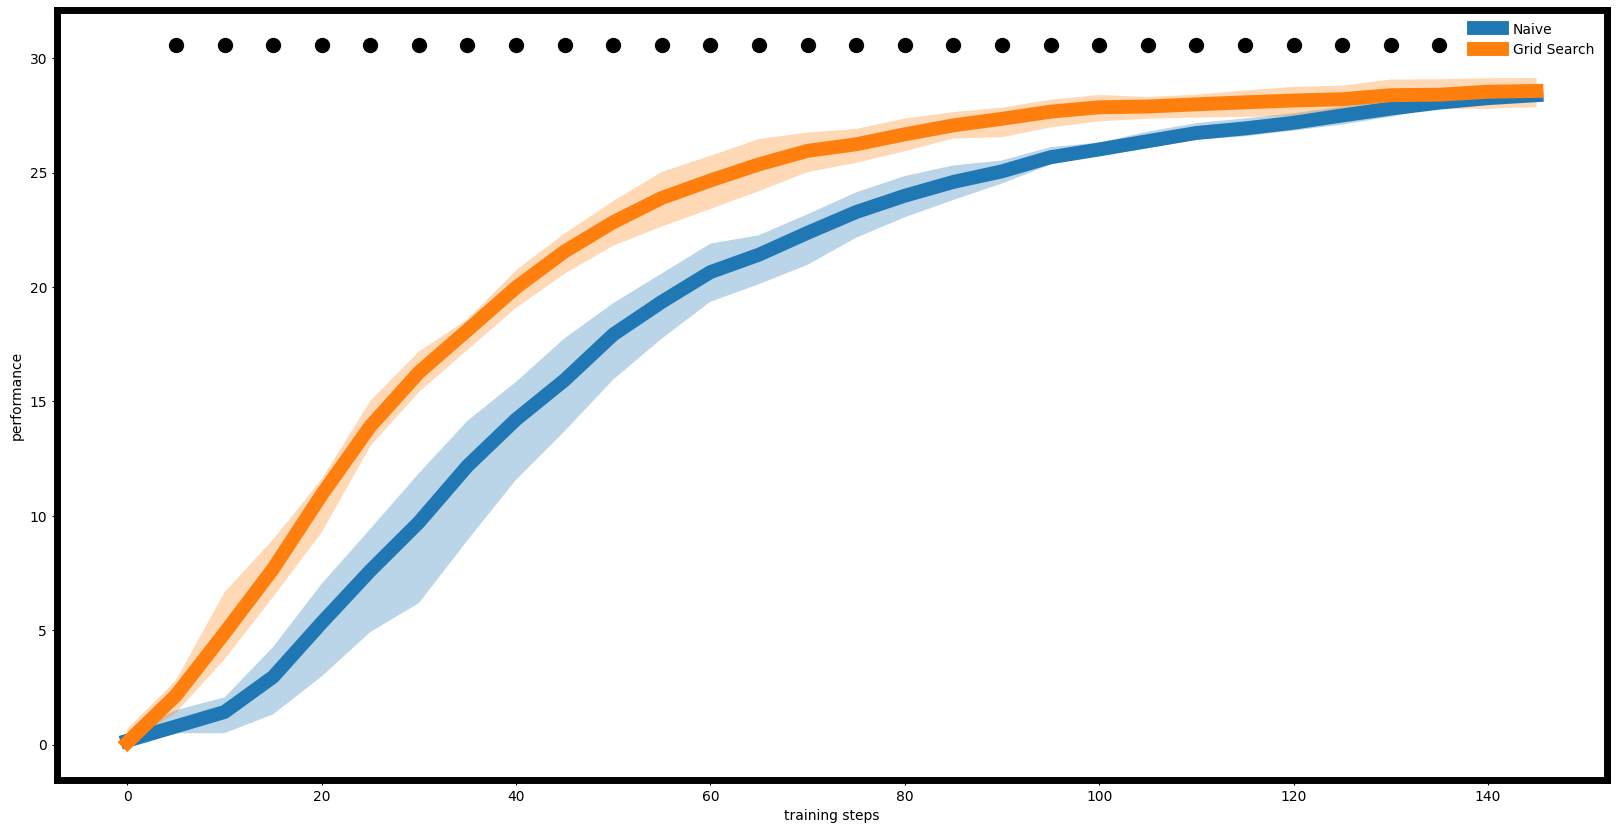

In [62]:
# Perform statistical comparisons

# Naive vs Grid Search
perform_test(perf1=naive_curves, perf2=grid_search_curves, name1='Naive', name2='Grid Search')

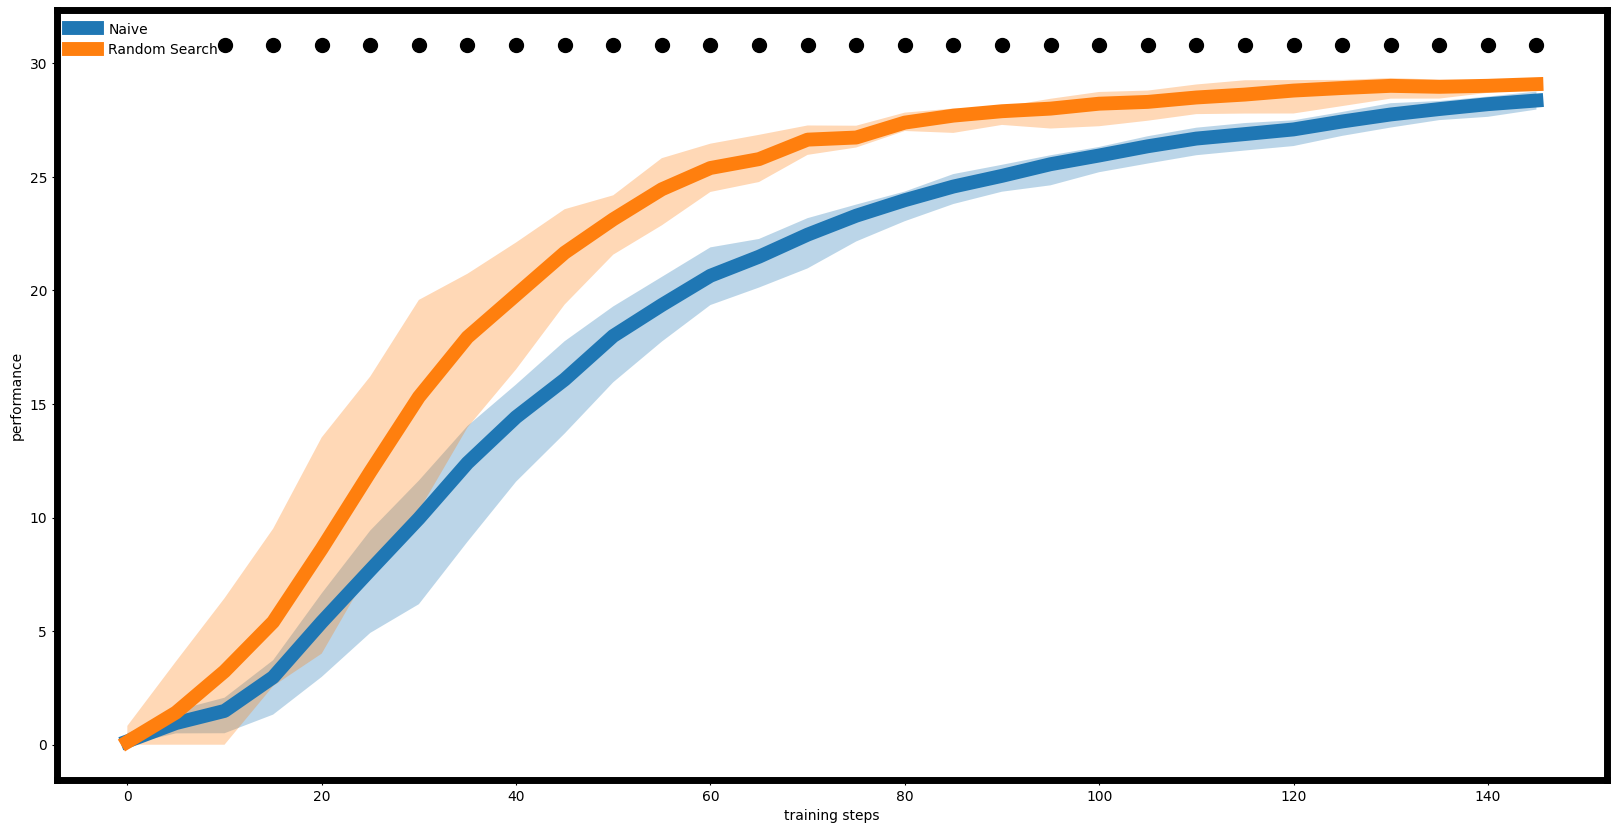

In [63]:
# Naive vs Random Search
perform_test(perf1=naive_curves, perf2=random_search_curves, name1='Naive', name2='Random Search')

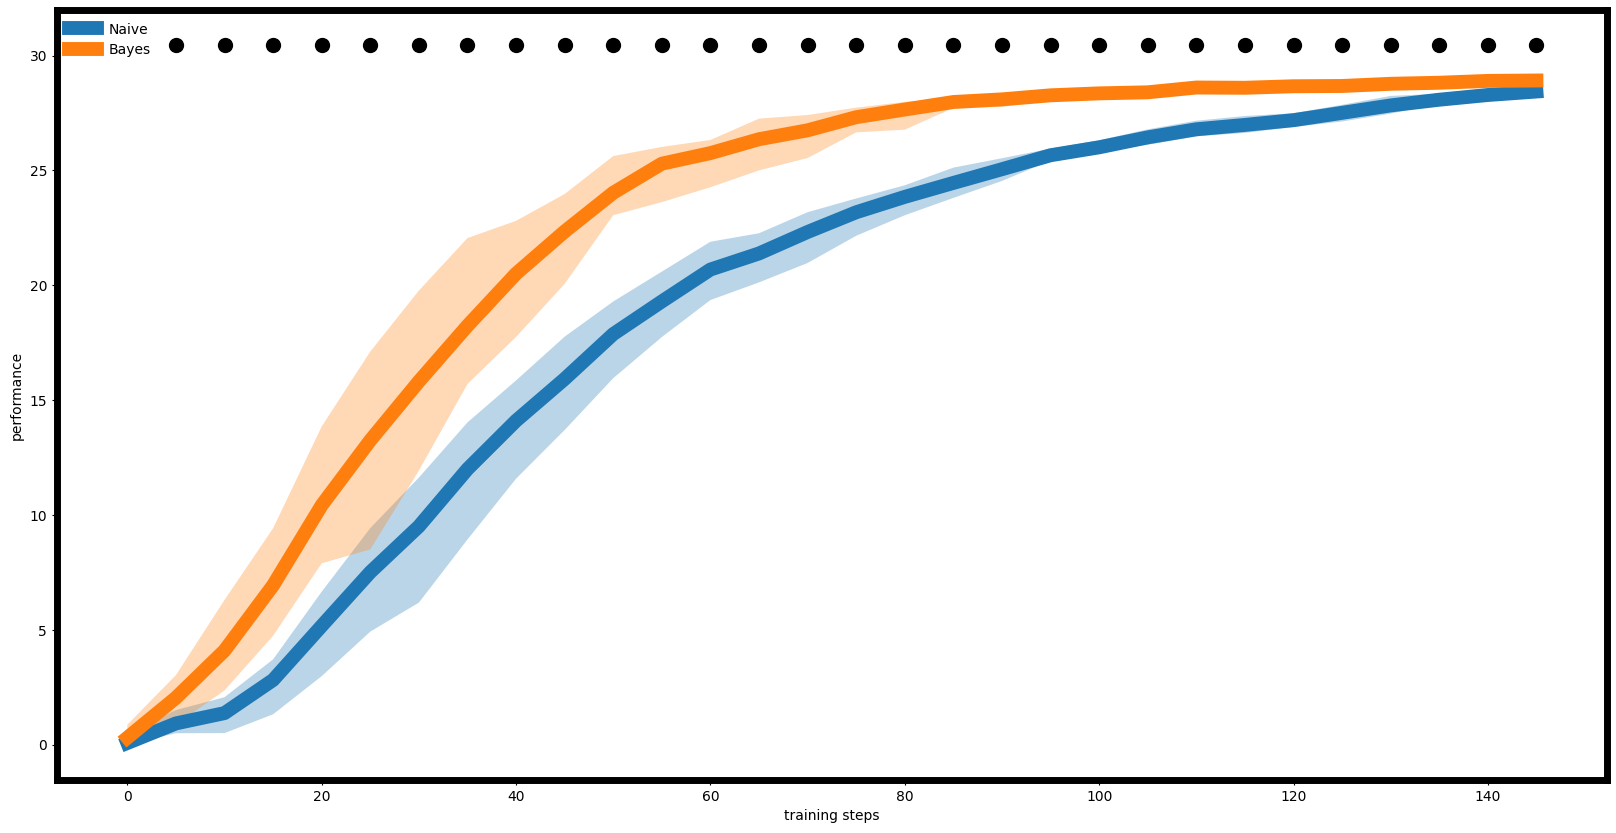

In [64]:
# Naive vs Bayes
perform_test(perf1=naive_curves, perf2=Bayes_curves, name1='Naive', name2='Bayes')

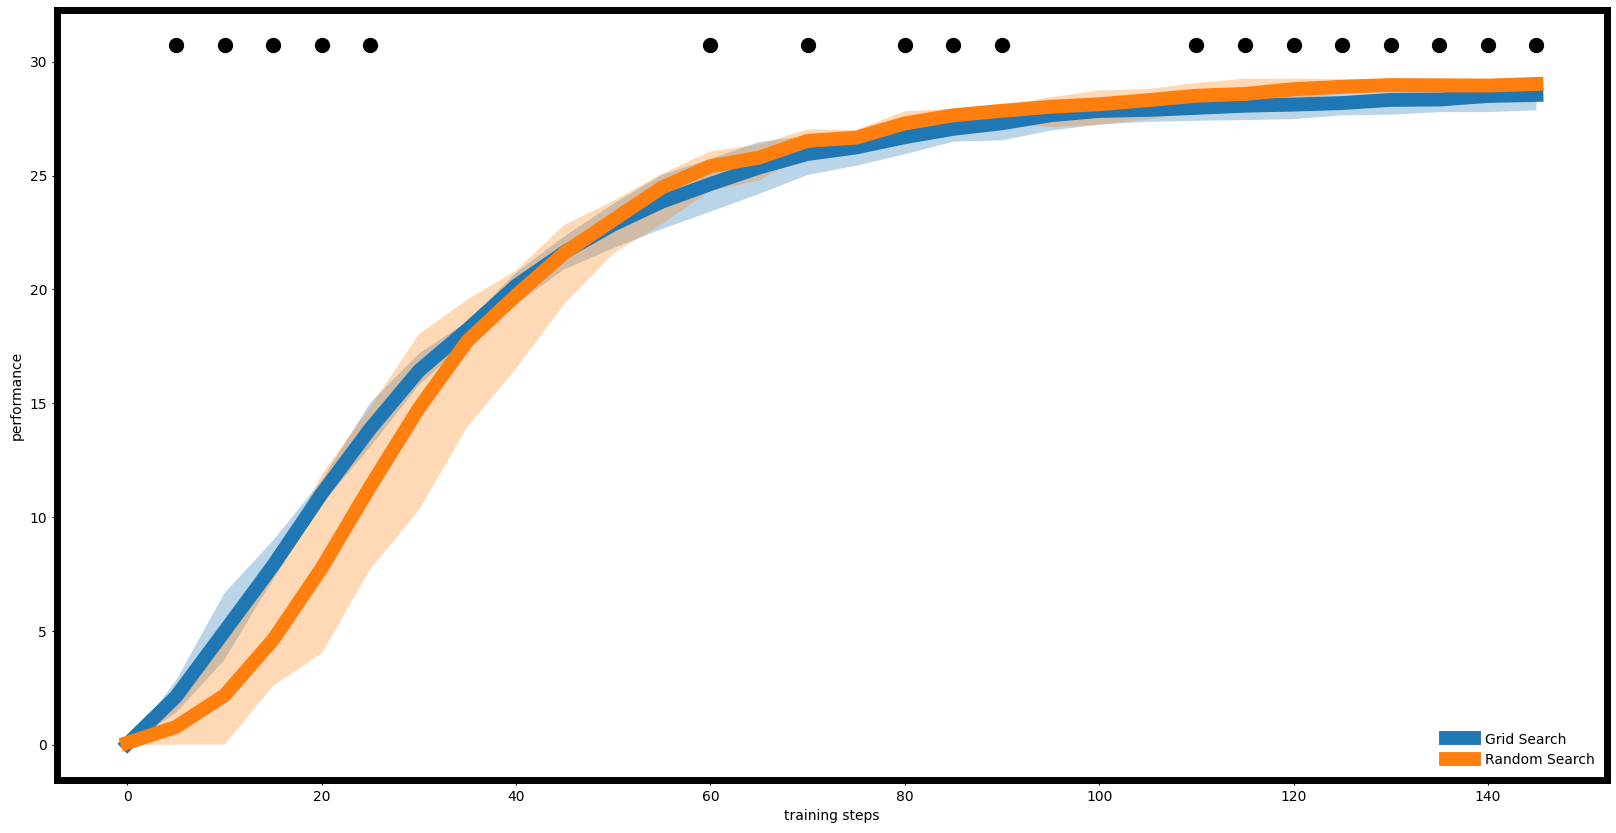

In [65]:
# Grid Search vs Random Search
perform_test(perf1=grid_search_curves, perf2=random_search_curves, name1='Grid Search', name2='Random Search')

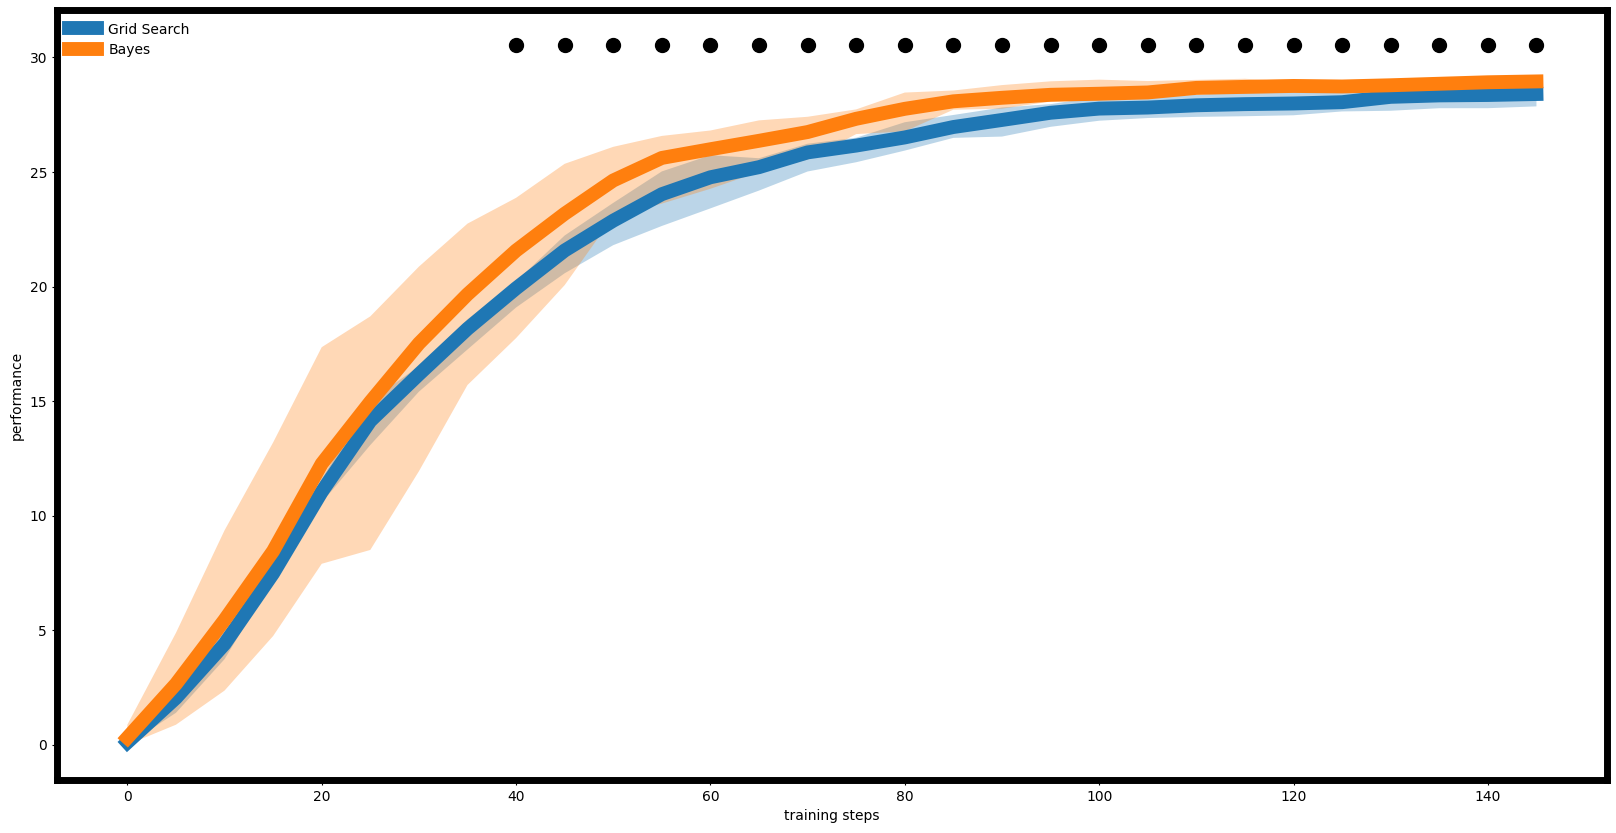

In [66]:
# Grid Search vs Bayes
perform_test(perf1=grid_search_curves, perf2=Bayes_curves, name1='Grid Search', name2='Bayes')

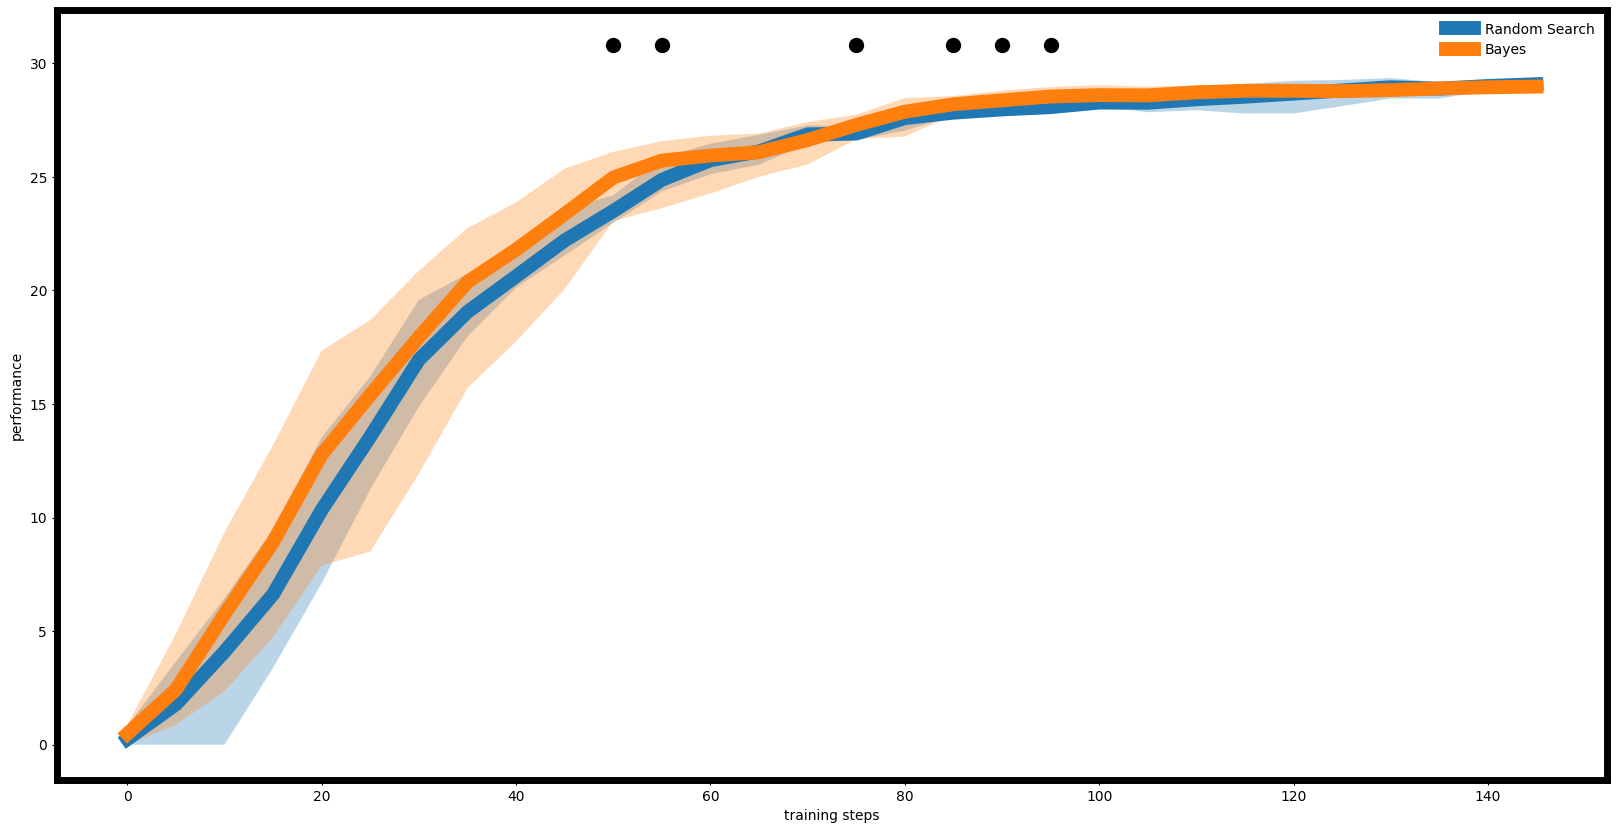

In [67]:
# Random Search vs Bayes
perform_test(perf1=random_search_curves, perf2=Bayes_curves, name1='Random Search', name2='Bayes')

n_num=15

In [68]:
# naive tuning
naive_alpha_critic = 0.5
naive_alpha_actor = 0.5

naive_curves = collect_learning_curves(
    mdp=env,
    num_runs=15,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=naive_alpha_actor,
    alpha_critic=naive_alpha_critic,
    render=ac_params['render']
)

In [69]:
# Grid Search tuning
grid_search_curves = collect_learning_curves(
    mdp = env,
    num_runs=15,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr,
    alpha_actor=best_actor_lr,
    render=ac_params['render'])

In [70]:
# Random Search tuning
random_search_curves = collect_learning_curves(
    mdp=env,
    num_runs=15,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr_random,
    alpha_actor=best_actor_lr_random,
    render=ac_params['render']
)

In [71]:
# Bayesian optimization method tuning (optuna)
Bayes_alpha_critic = study.best_params["alpha_critic"]
Bayes_alpha_actor = study.best_params["alpha_actor"]

Bayes_curves = collect_learning_curves(
    mdp=env,
    num_runs=15,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=Bayes_alpha_actor,
    alpha_critic=Bayes_alpha_critic,
    render=ac_params['render']
)

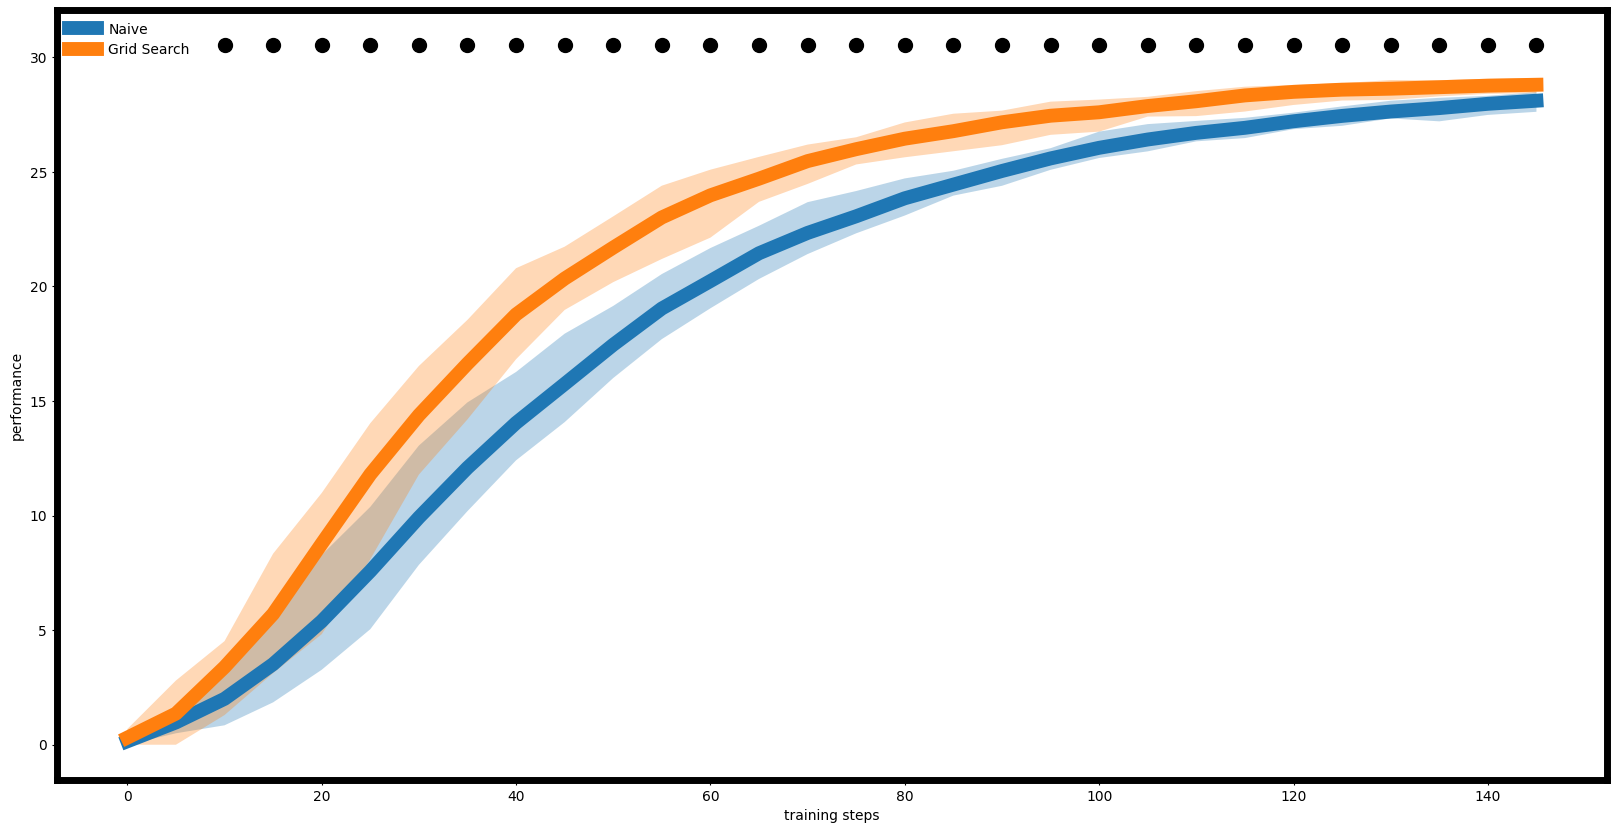

In [72]:
# Perform statistical comparisons

# Naive vs Grid Search
perform_test(perf1=naive_curves, perf2=grid_search_curves, name1='Naive', name2='Grid Search')

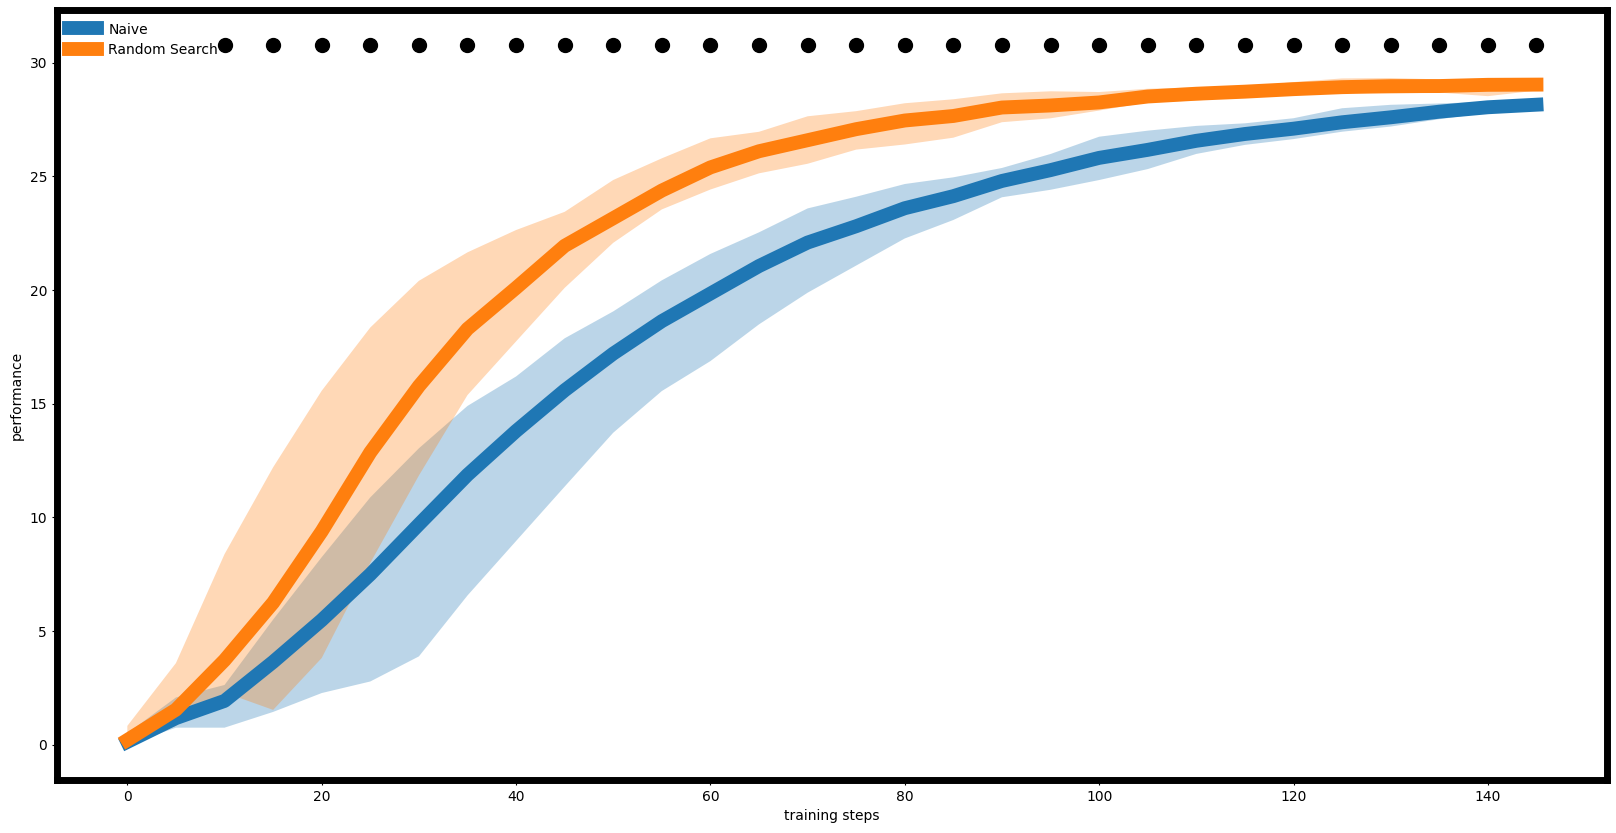

In [73]:
# Naive vs Random Search
perform_test(perf1=naive_curves, perf2=random_search_curves, name1='Naive', name2='Random Search')

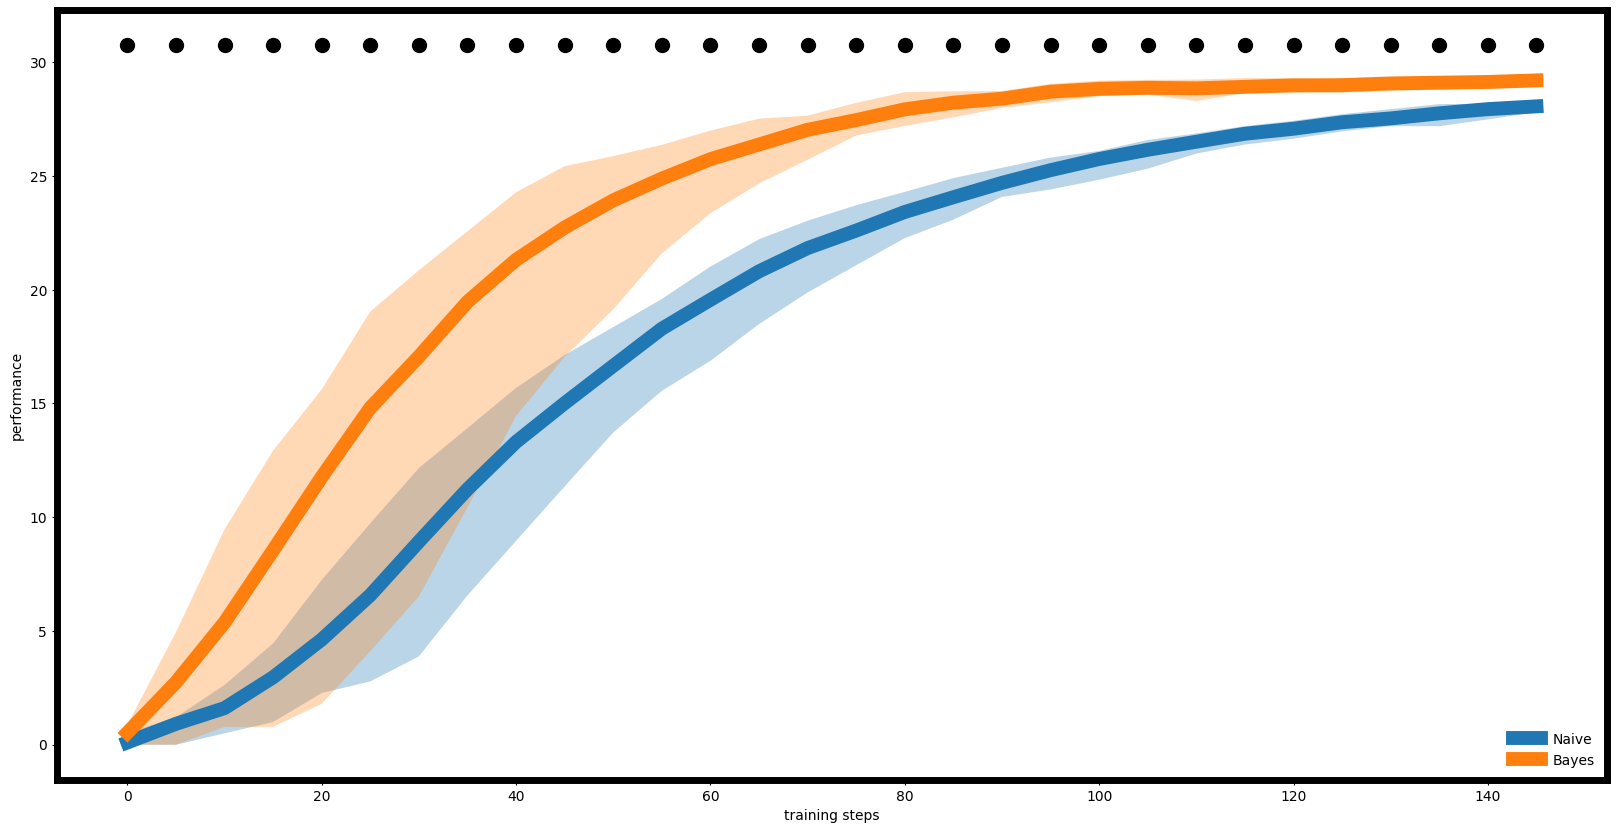

In [74]:
# Naive vs Bayes
perform_test(perf1=naive_curves, perf2=Bayes_curves, name1='Naive', name2='Bayes')

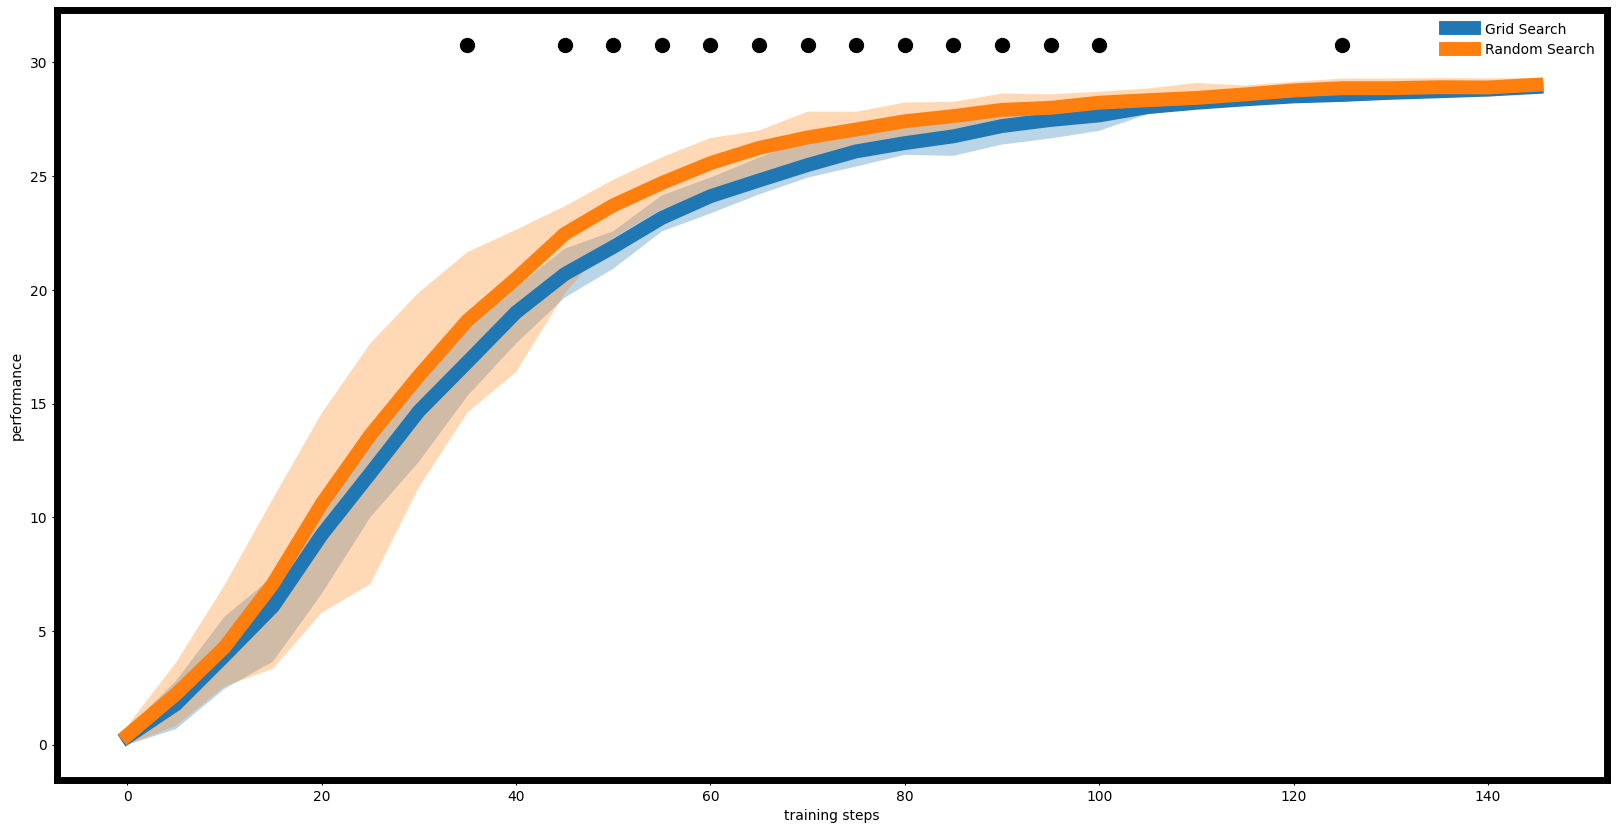

In [75]:
# Grid Search vs Random Search
perform_test(perf1=grid_search_curves, perf2=random_search_curves, name1='Grid Search', name2='Random Search')

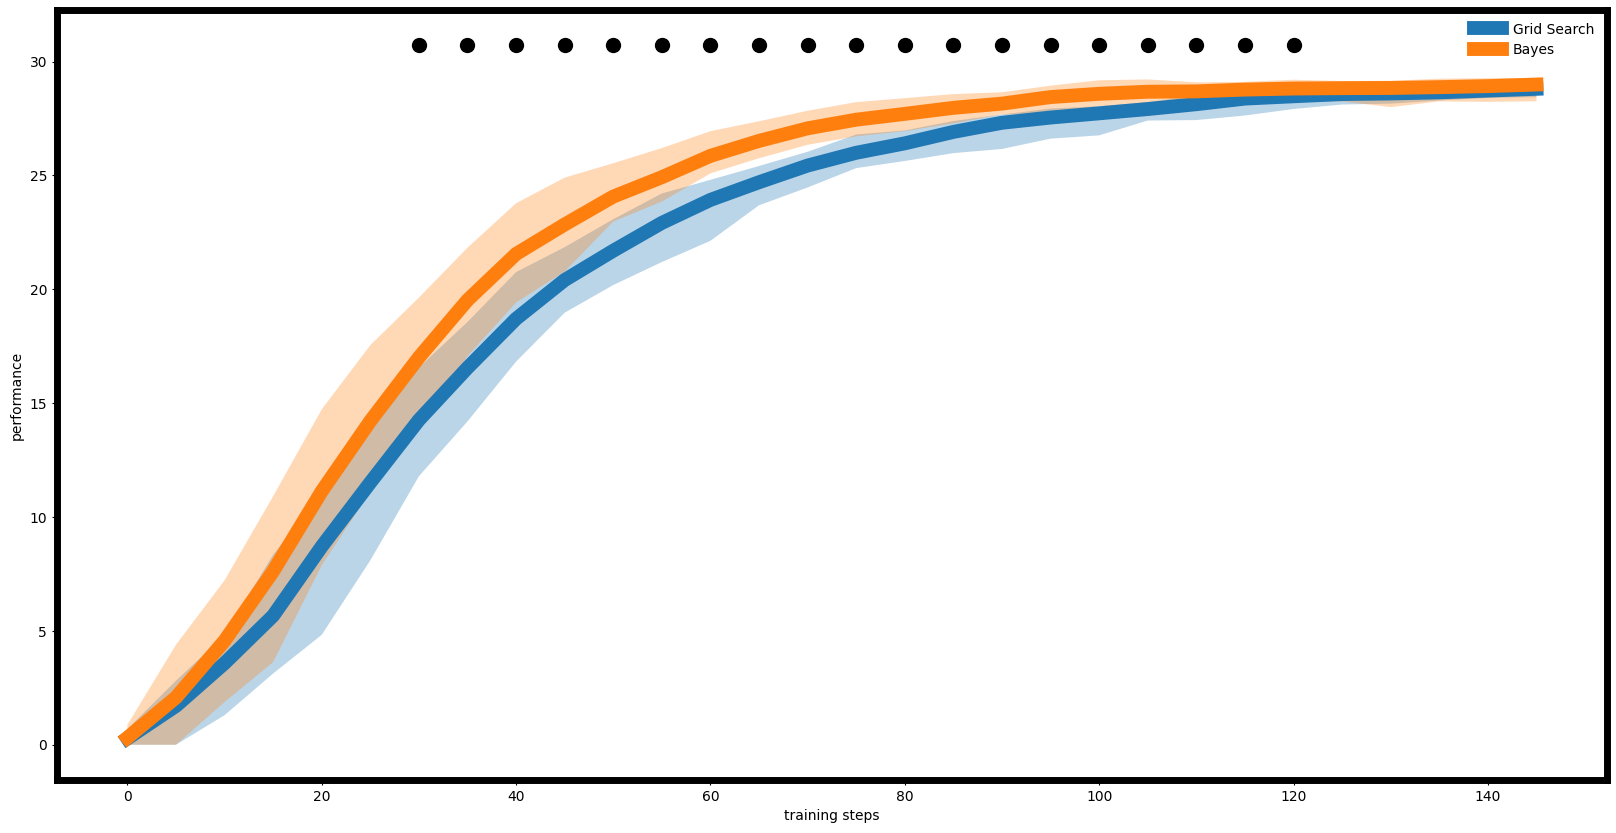

In [76]:
# Grid Search vs Bayes
perform_test(perf1=grid_search_curves, perf2=Bayes_curves, name1='Grid Search', name2='Bayes')

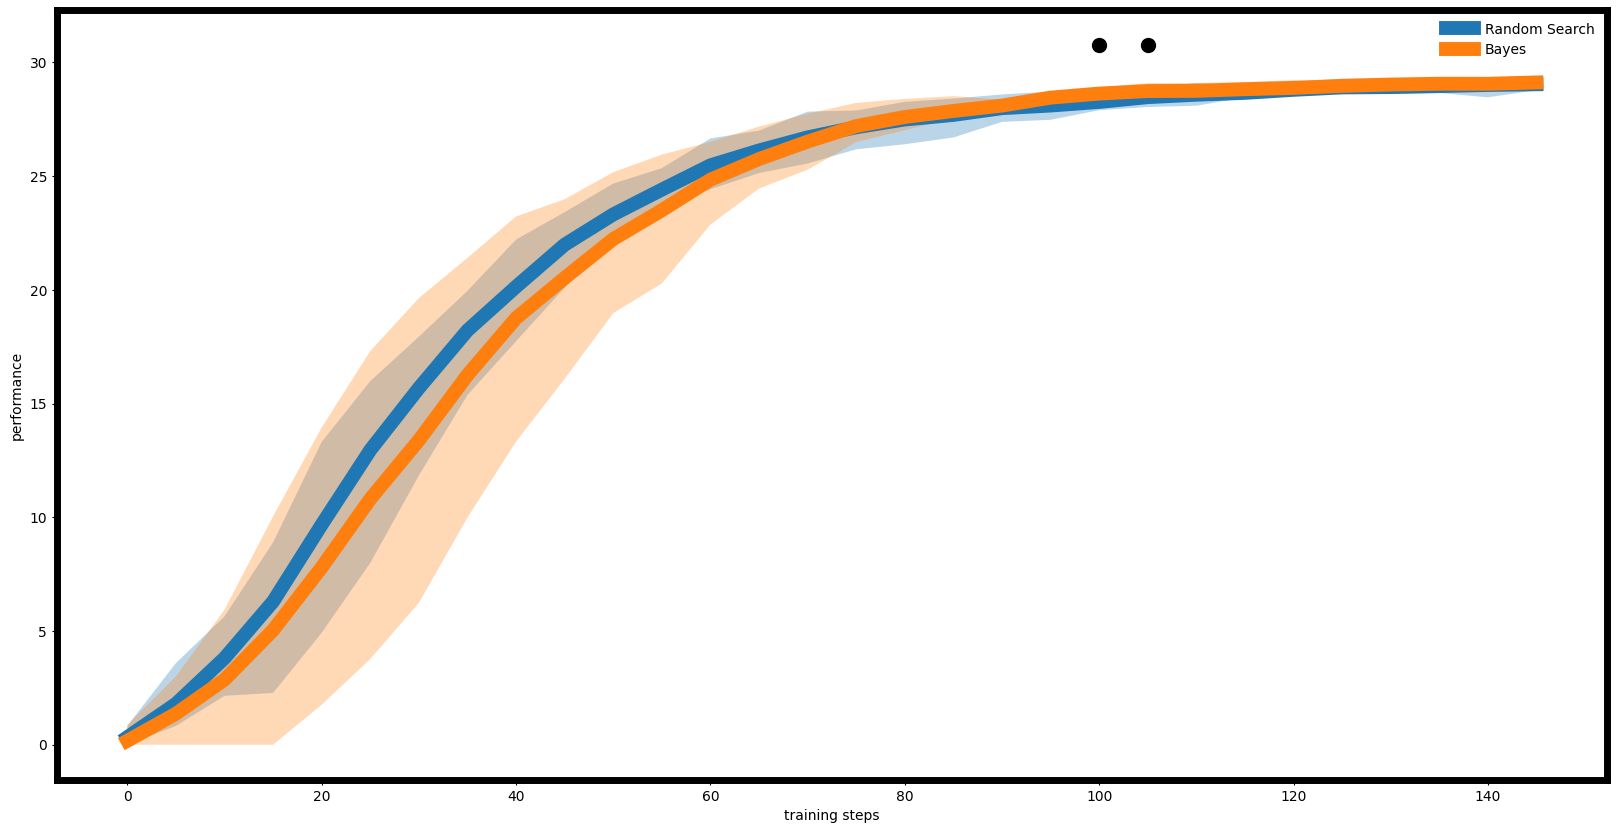

In [77]:
# Random Search vs Bayes
perform_test(perf1=random_search_curves, perf2=Bayes_curves, name1='Random Search', name2='Bayes')

n_num=50

In [78]:
# naive tuning
naive_alpha_critic = 0.5
naive_alpha_actor = 0.5

naive_curves = collect_learning_curves(
    mdp=env,
    num_runs=50,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=naive_alpha_actor,
    alpha_critic=naive_alpha_critic,
    render=ac_params['render']
)

In [79]:
# Grid Search tuning
grid_search_curves = collect_learning_curves(
    mdp = env,
    num_runs=50,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr,
    alpha_actor=best_actor_lr,
    render=ac_params['render'])

In [80]:
# Random Search tuning
random_search_curves = collect_learning_curves(
    mdp=env,
    num_runs=50,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_critic=best_critic_lr_random,
    alpha_actor=best_actor_lr_random,
    render=ac_params['render']
)

In [81]:
# Bayesian optimization method tuning (optuna)
Bayes_alpha_critic = study.best_params["alpha_critic"]
Bayes_alpha_actor = study.best_params["alpha_actor"]

Bayes_curves = collect_learning_curves(
    mdp=env,
    num_runs=50,
    nb_episodes=150,
    timeout=ac_params['timeout'],
    alpha_actor=Bayes_alpha_actor,
    alpha_critic=Bayes_alpha_critic,
    render=ac_params['render']
)

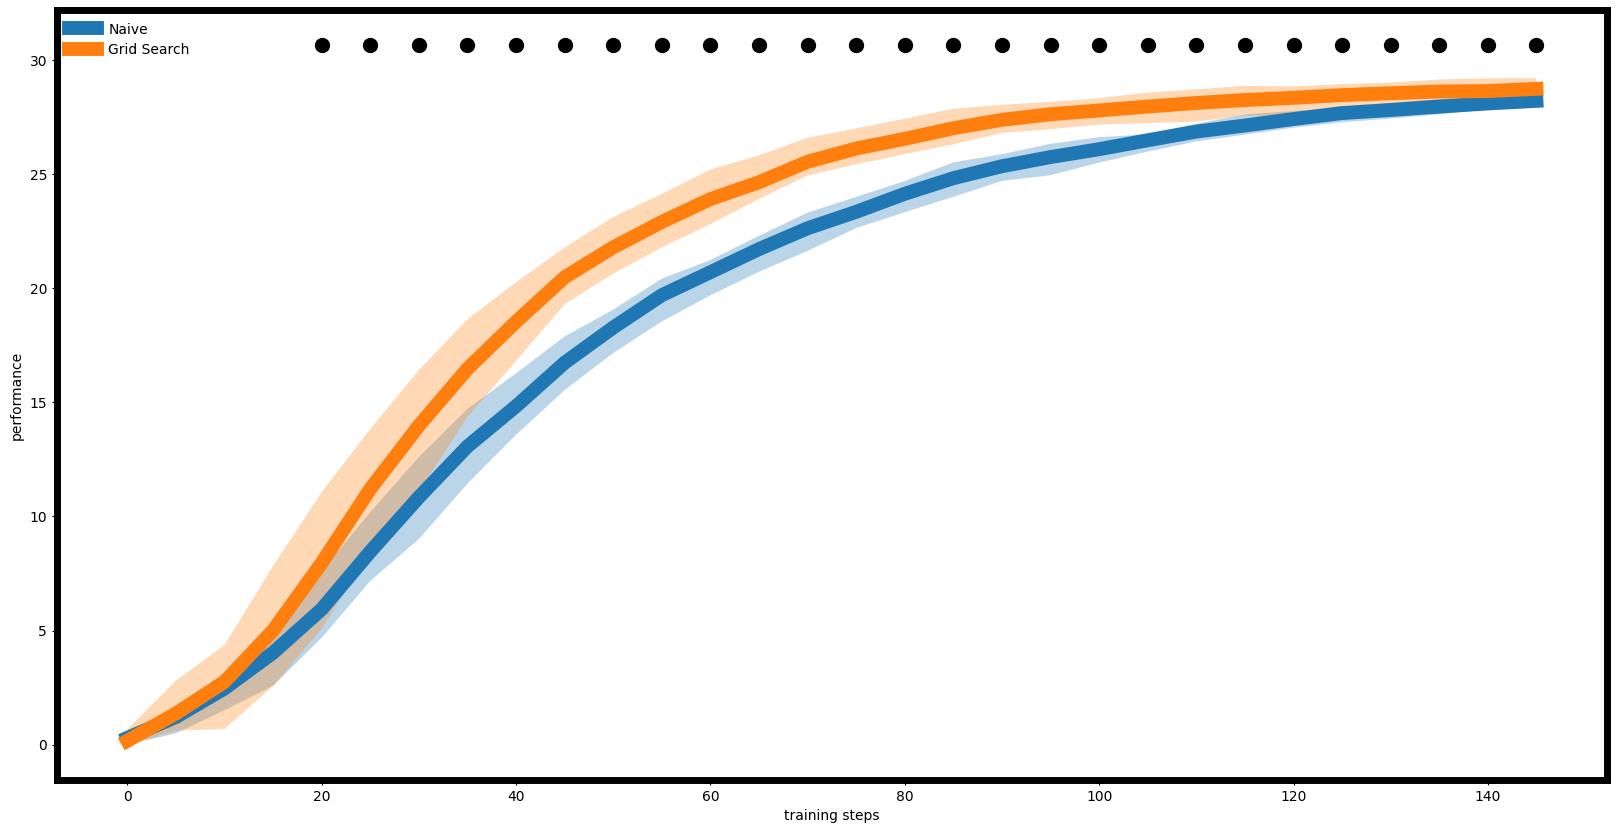

In [82]:
# Perform statistical comparisons

# Naive vs Grid Search
perform_test(perf1=naive_curves, perf2=grid_search_curves, name1='Naive', name2='Grid Search')

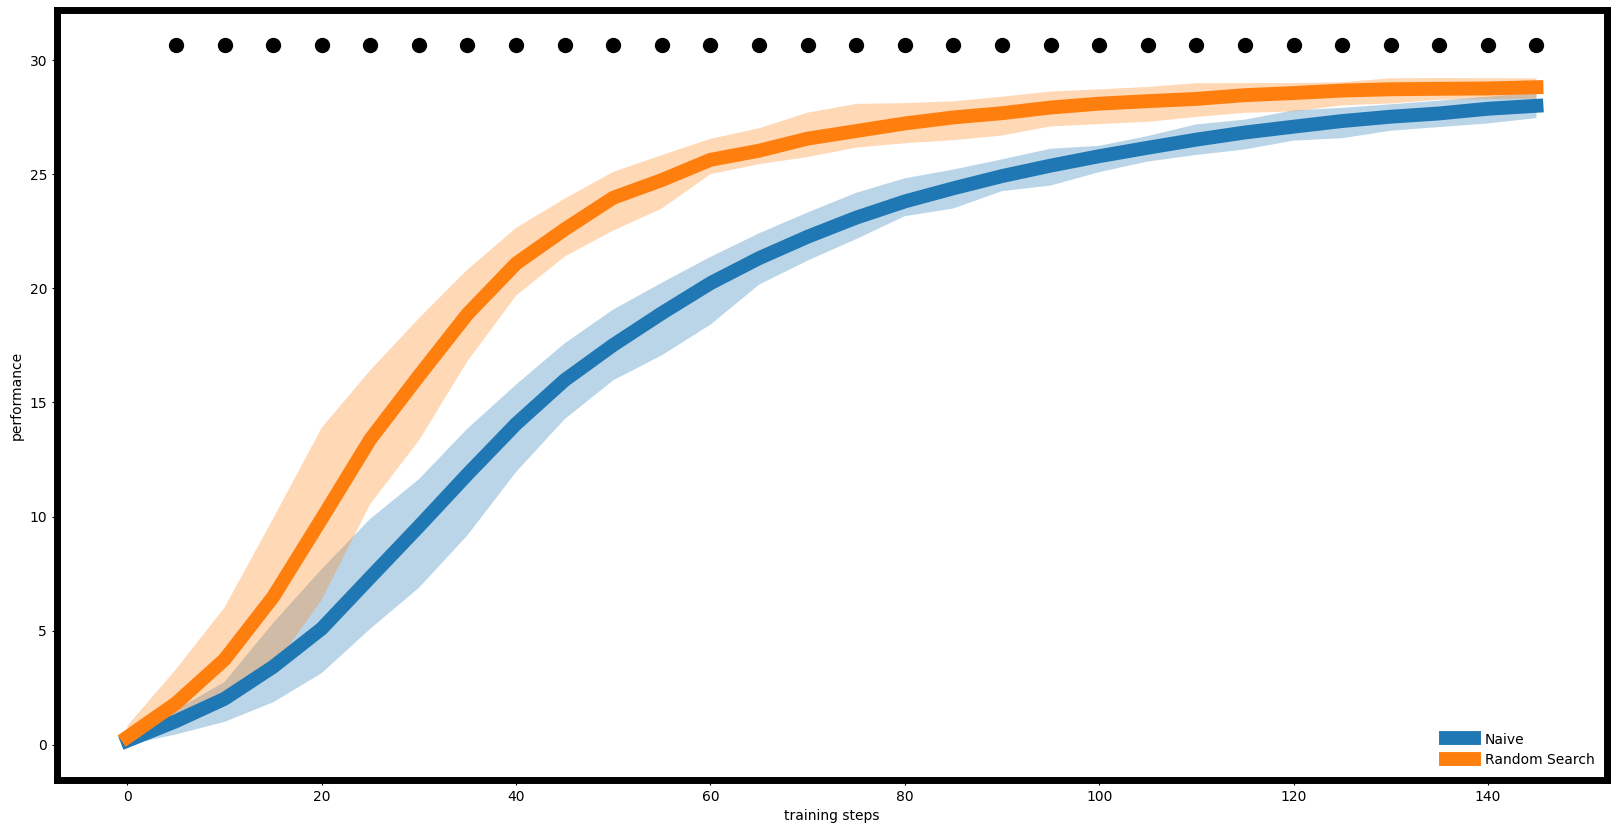

In [83]:
# Naive vs Random Search
perform_test(perf1=naive_curves, perf2=random_search_curves, name1='Naive', name2='Random Search')

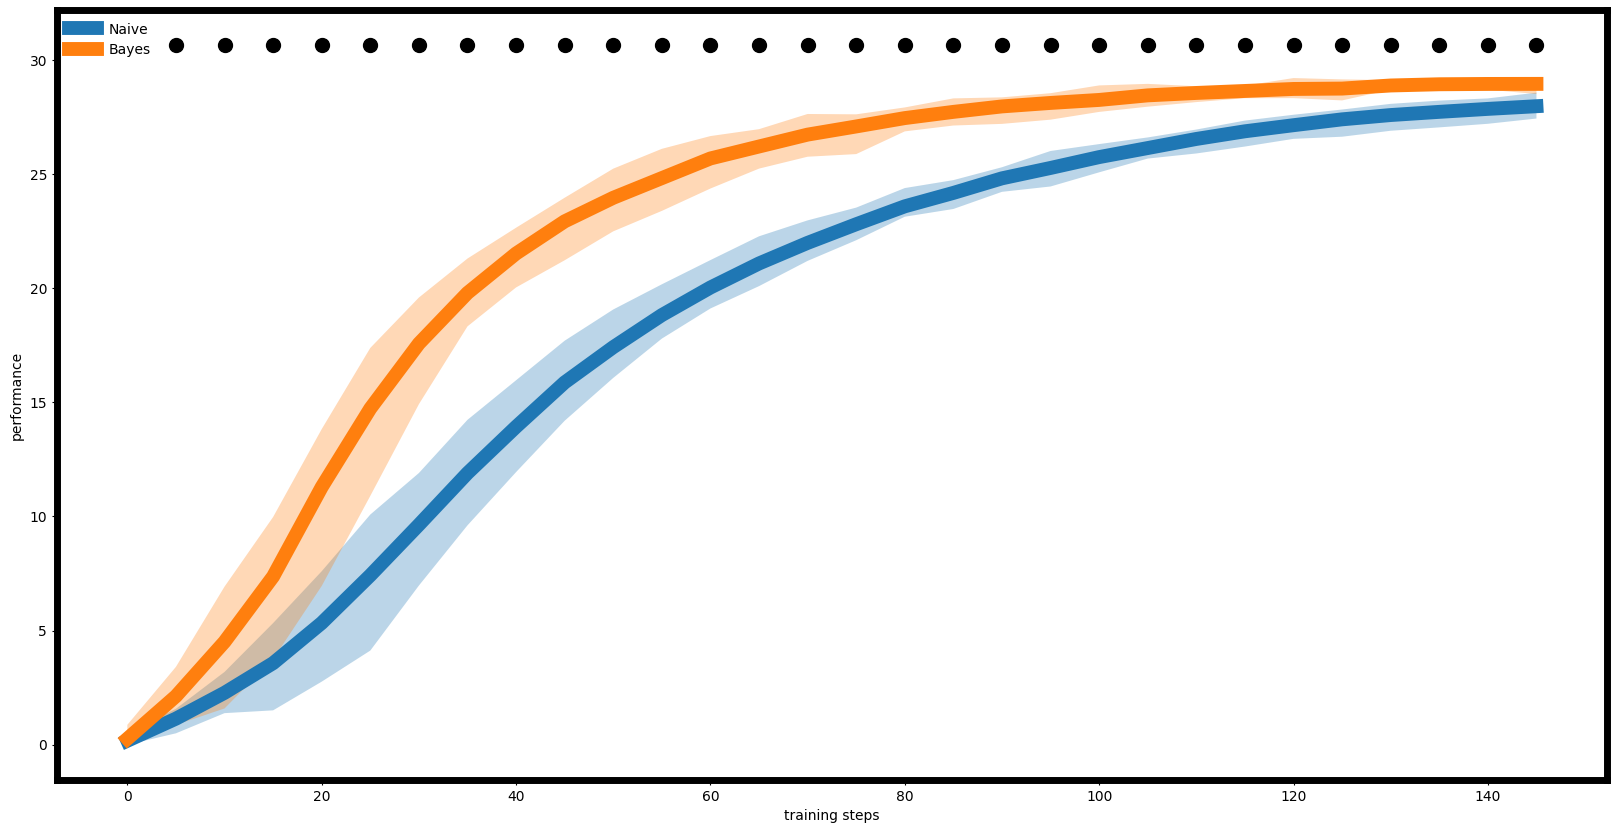

In [84]:
# Naive vs Bayes
perform_test(perf1=naive_curves, perf2=Bayes_curves, name1='Naive', name2='Bayes')

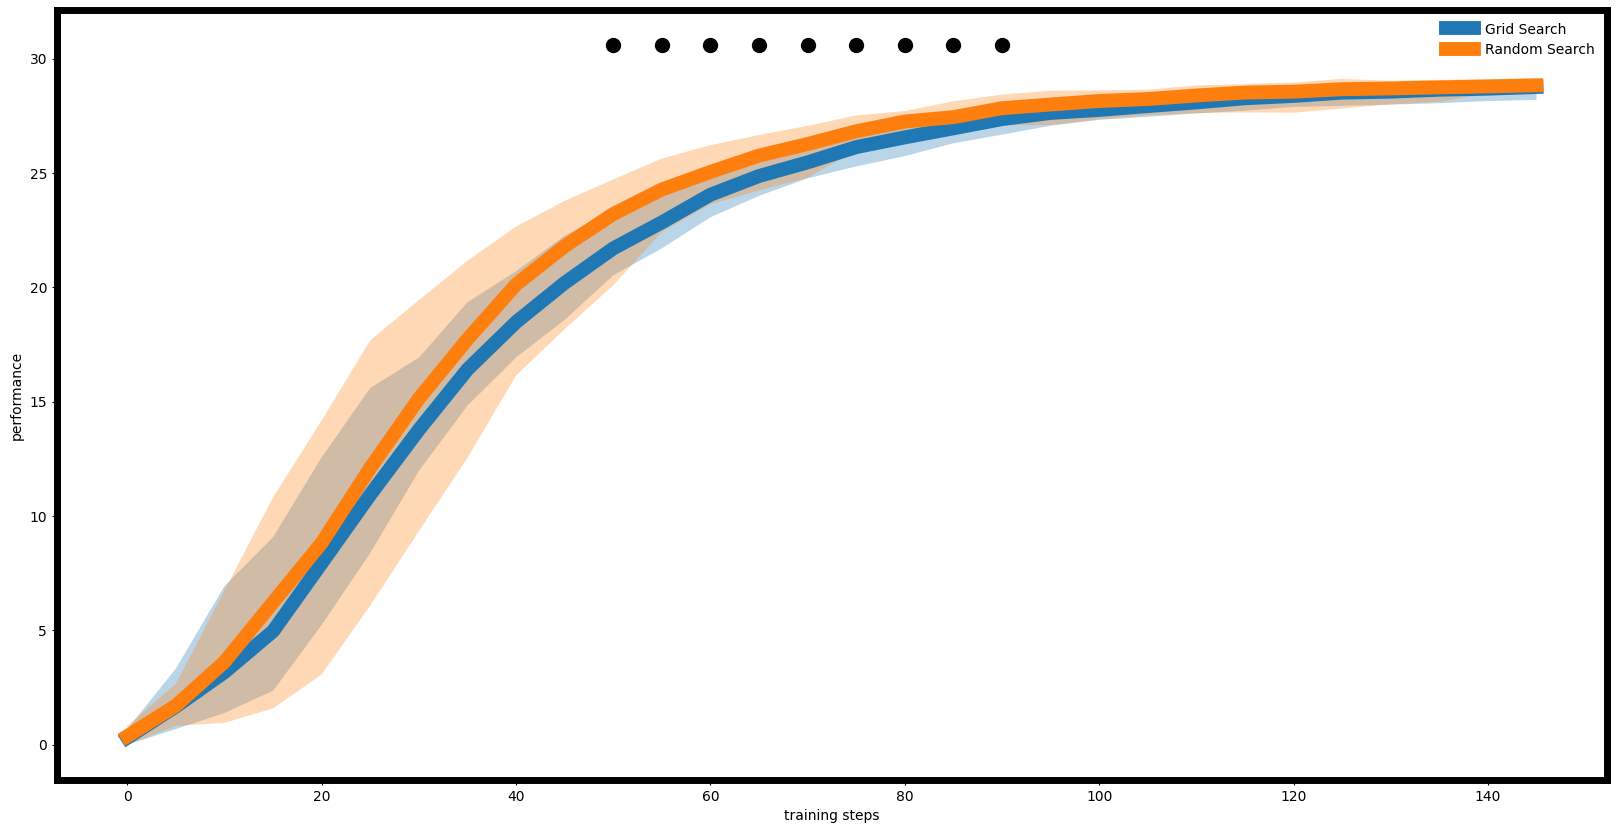

In [85]:
# Grid Search vs Random Search
perform_test(perf1=grid_search_curves, perf2=random_search_curves, name1='Grid Search', name2='Random Search')

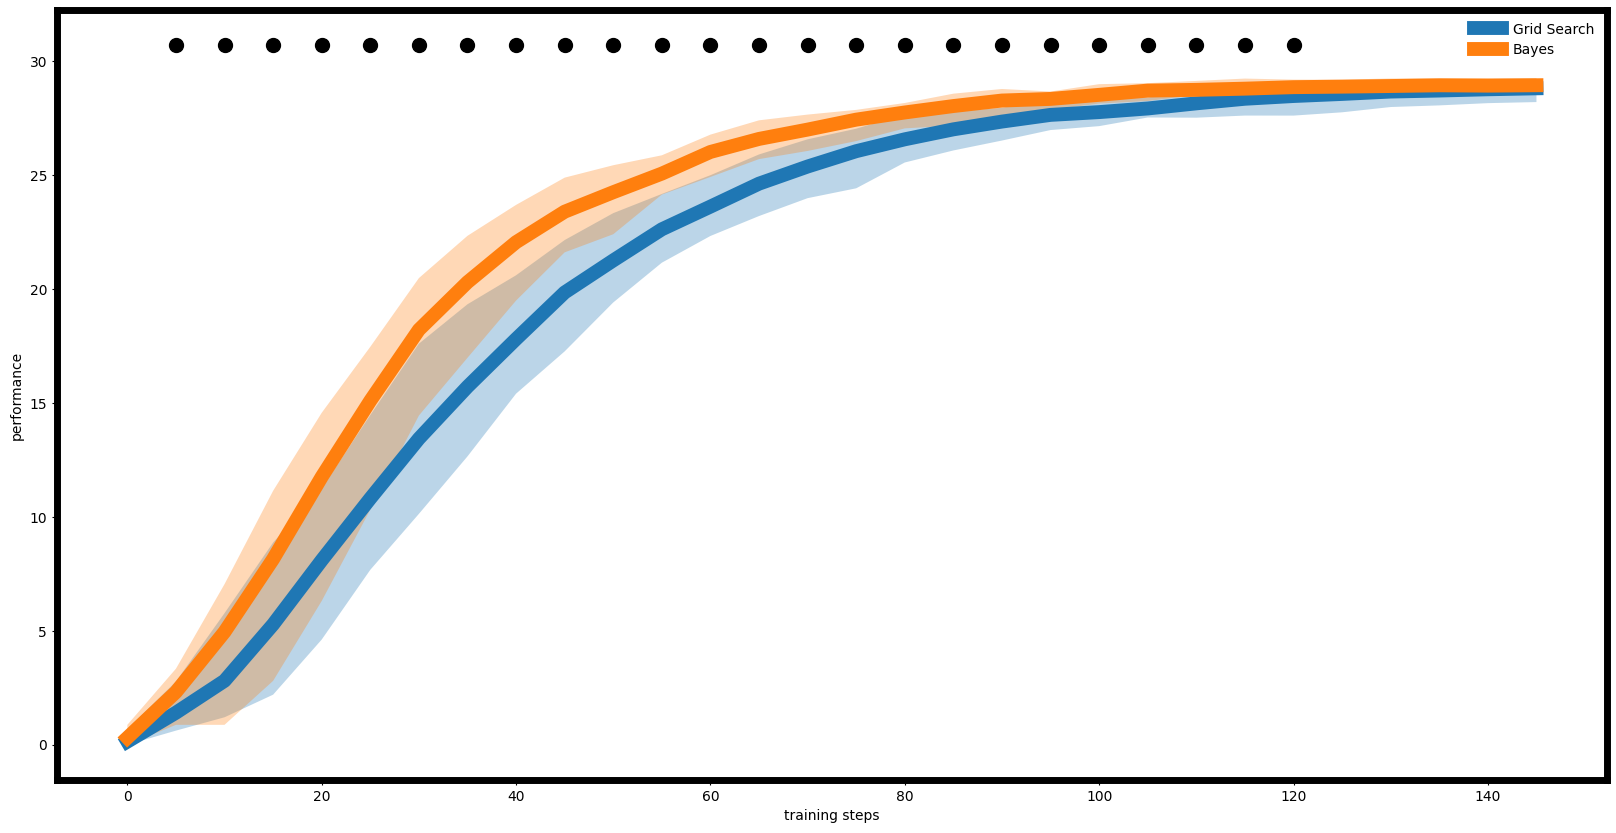

In [86]:
# Grid Search vs Bayes
perform_test(perf1=grid_search_curves, perf2=Bayes_curves, name1='Grid Search', name2='Bayes')

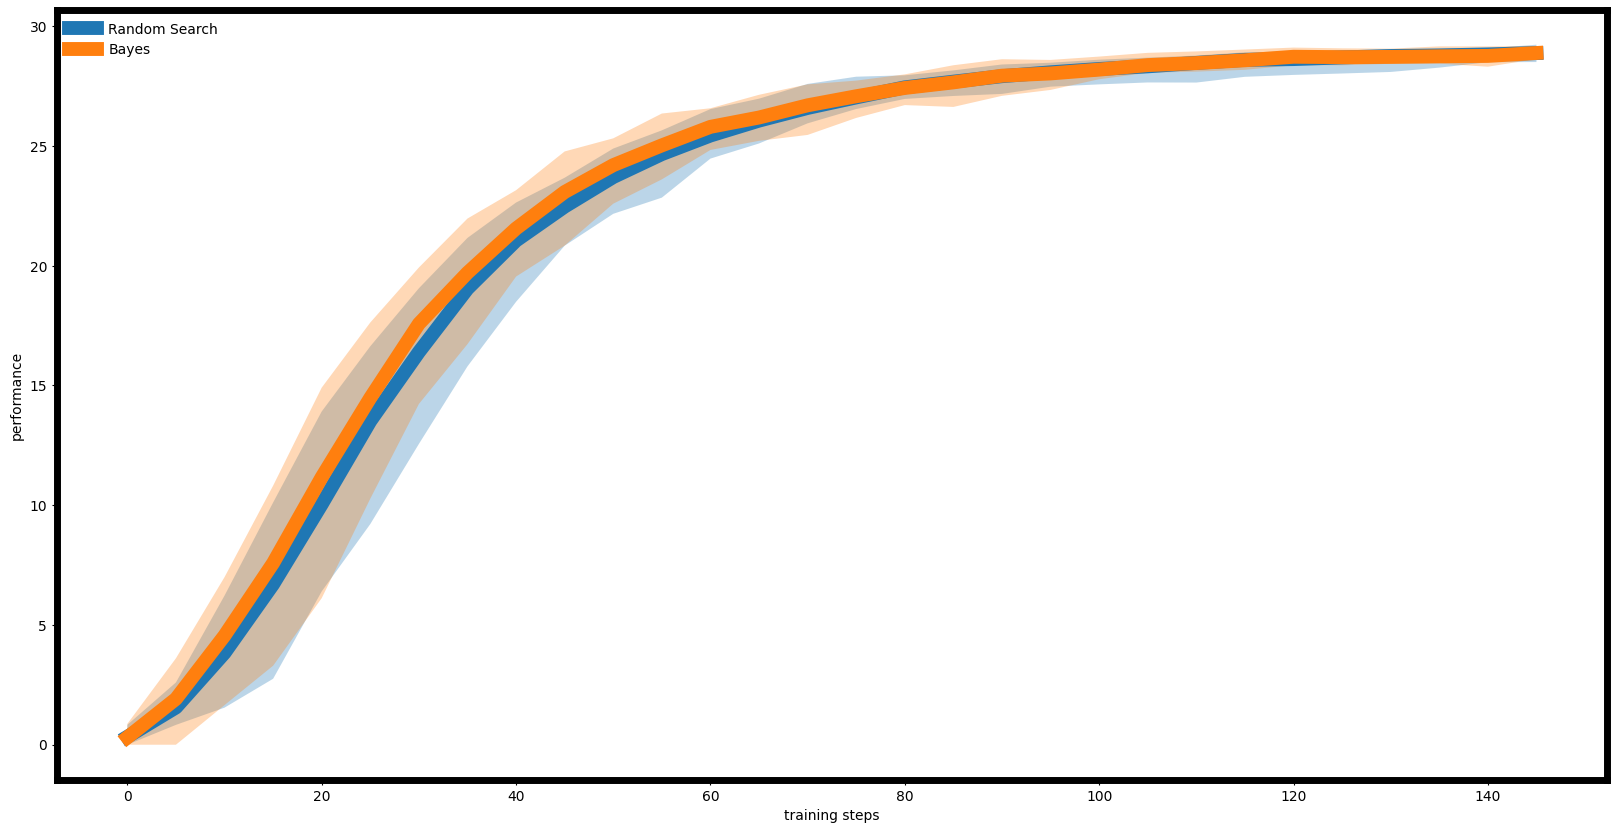

In [87]:
# Random Search vs Bayes
perform_test(perf1=random_search_curves, perf2=Bayes_curves, name1='Random Search', name2='Bayes')

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of the choices you have made: the parameters you have set, the libraries you have used, etc.,
    + the heatmaps obtained using the hyper-parameters tuning algorithms that you have used,
    + the figures resulting from performing Welch's T-test using the best hyper-parameters from the above approaches,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can try using a Q-function as critic, using random search as hyper-parameters tuning algorithm,
using more challenging environments, etc.